In [1]:
import sys
import os

# Adjust the path to point to your src directory
sys.path.insert(0, os.path.abspath('../../src'))

import xarray as xr

ds = xr.open_dataset('../../data/sukinda_25jul/sukinda_25jul.nc')

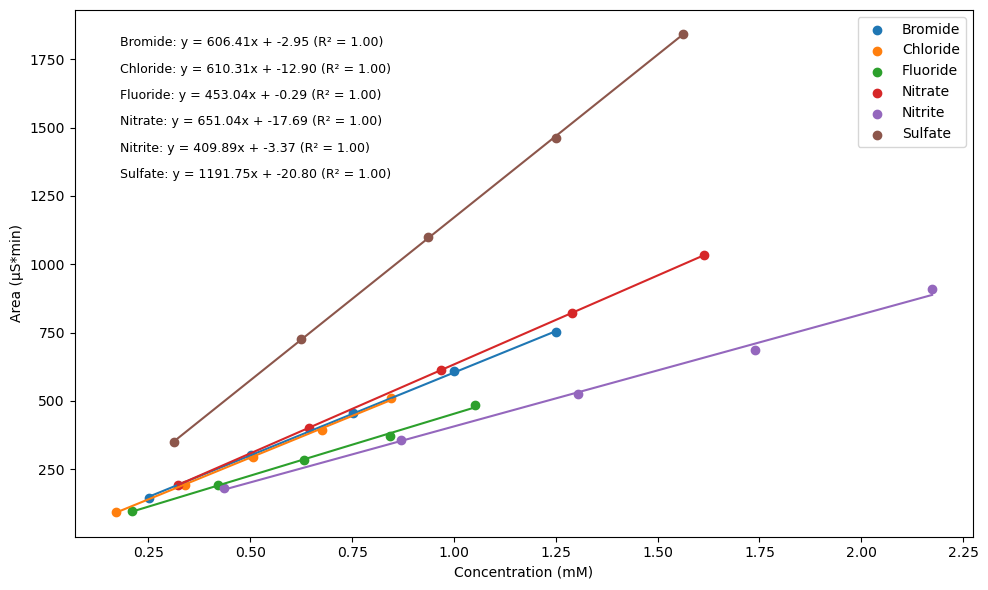

{'Bromide': {'slope': np.float64(606.4064547217417), 'intercept': np.float64(-2.9515304589901348), 'R2': 0.99968264692126}, 'Chloride': {'slope': np.float64(610.3143389014572), 'intercept': np.float64(-12.902016302292111), 'R2': 0.9993048548069148}, 'Fluoride': {'slope': np.float64(453.0358537854375), 'intercept': np.float64(-0.286304361005989), 'R2': 0.9980428364295032}, 'Nitrate': {'slope': np.float64(651.0449889225338), 'intercept': np.float64(-17.689399449516145), 'R2': 0.9999916032932676}, 'Nitrite': {'slope': np.float64(409.88686358167774), 'intercept': np.float64(-3.365565927278908), 'R2': 0.9965324978223462}, 'Sulfate': {'slope': np.float64(1191.749053911027), 'intercept': np.float64(-20.798482638974747), 'R2': 0.9999609772113751}}


In [2]:
from dionexus.calibration import assign_standard_concentrations

csv_file = "/Users/angus/work/sukinda/lab_work/anions/gabby_standards.csv"
calib_standard_samples = ['G-0', 'G-20', 'G-40', 'G-60', 'G-80', 'G-100']
dilution_factors = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ds = assign_standard_concentrations(ds, csv_file, calib_standard_samples, dilution_factors)


from dionexus.calibration import calibrate_species

coeffs = calibrate_species(ds, calib_standard_samples)
print(coeffs)

from dionexus.calibration import compute_concentrations

ds = compute_concentrations(ds, coeffs, calib_standard_samples)

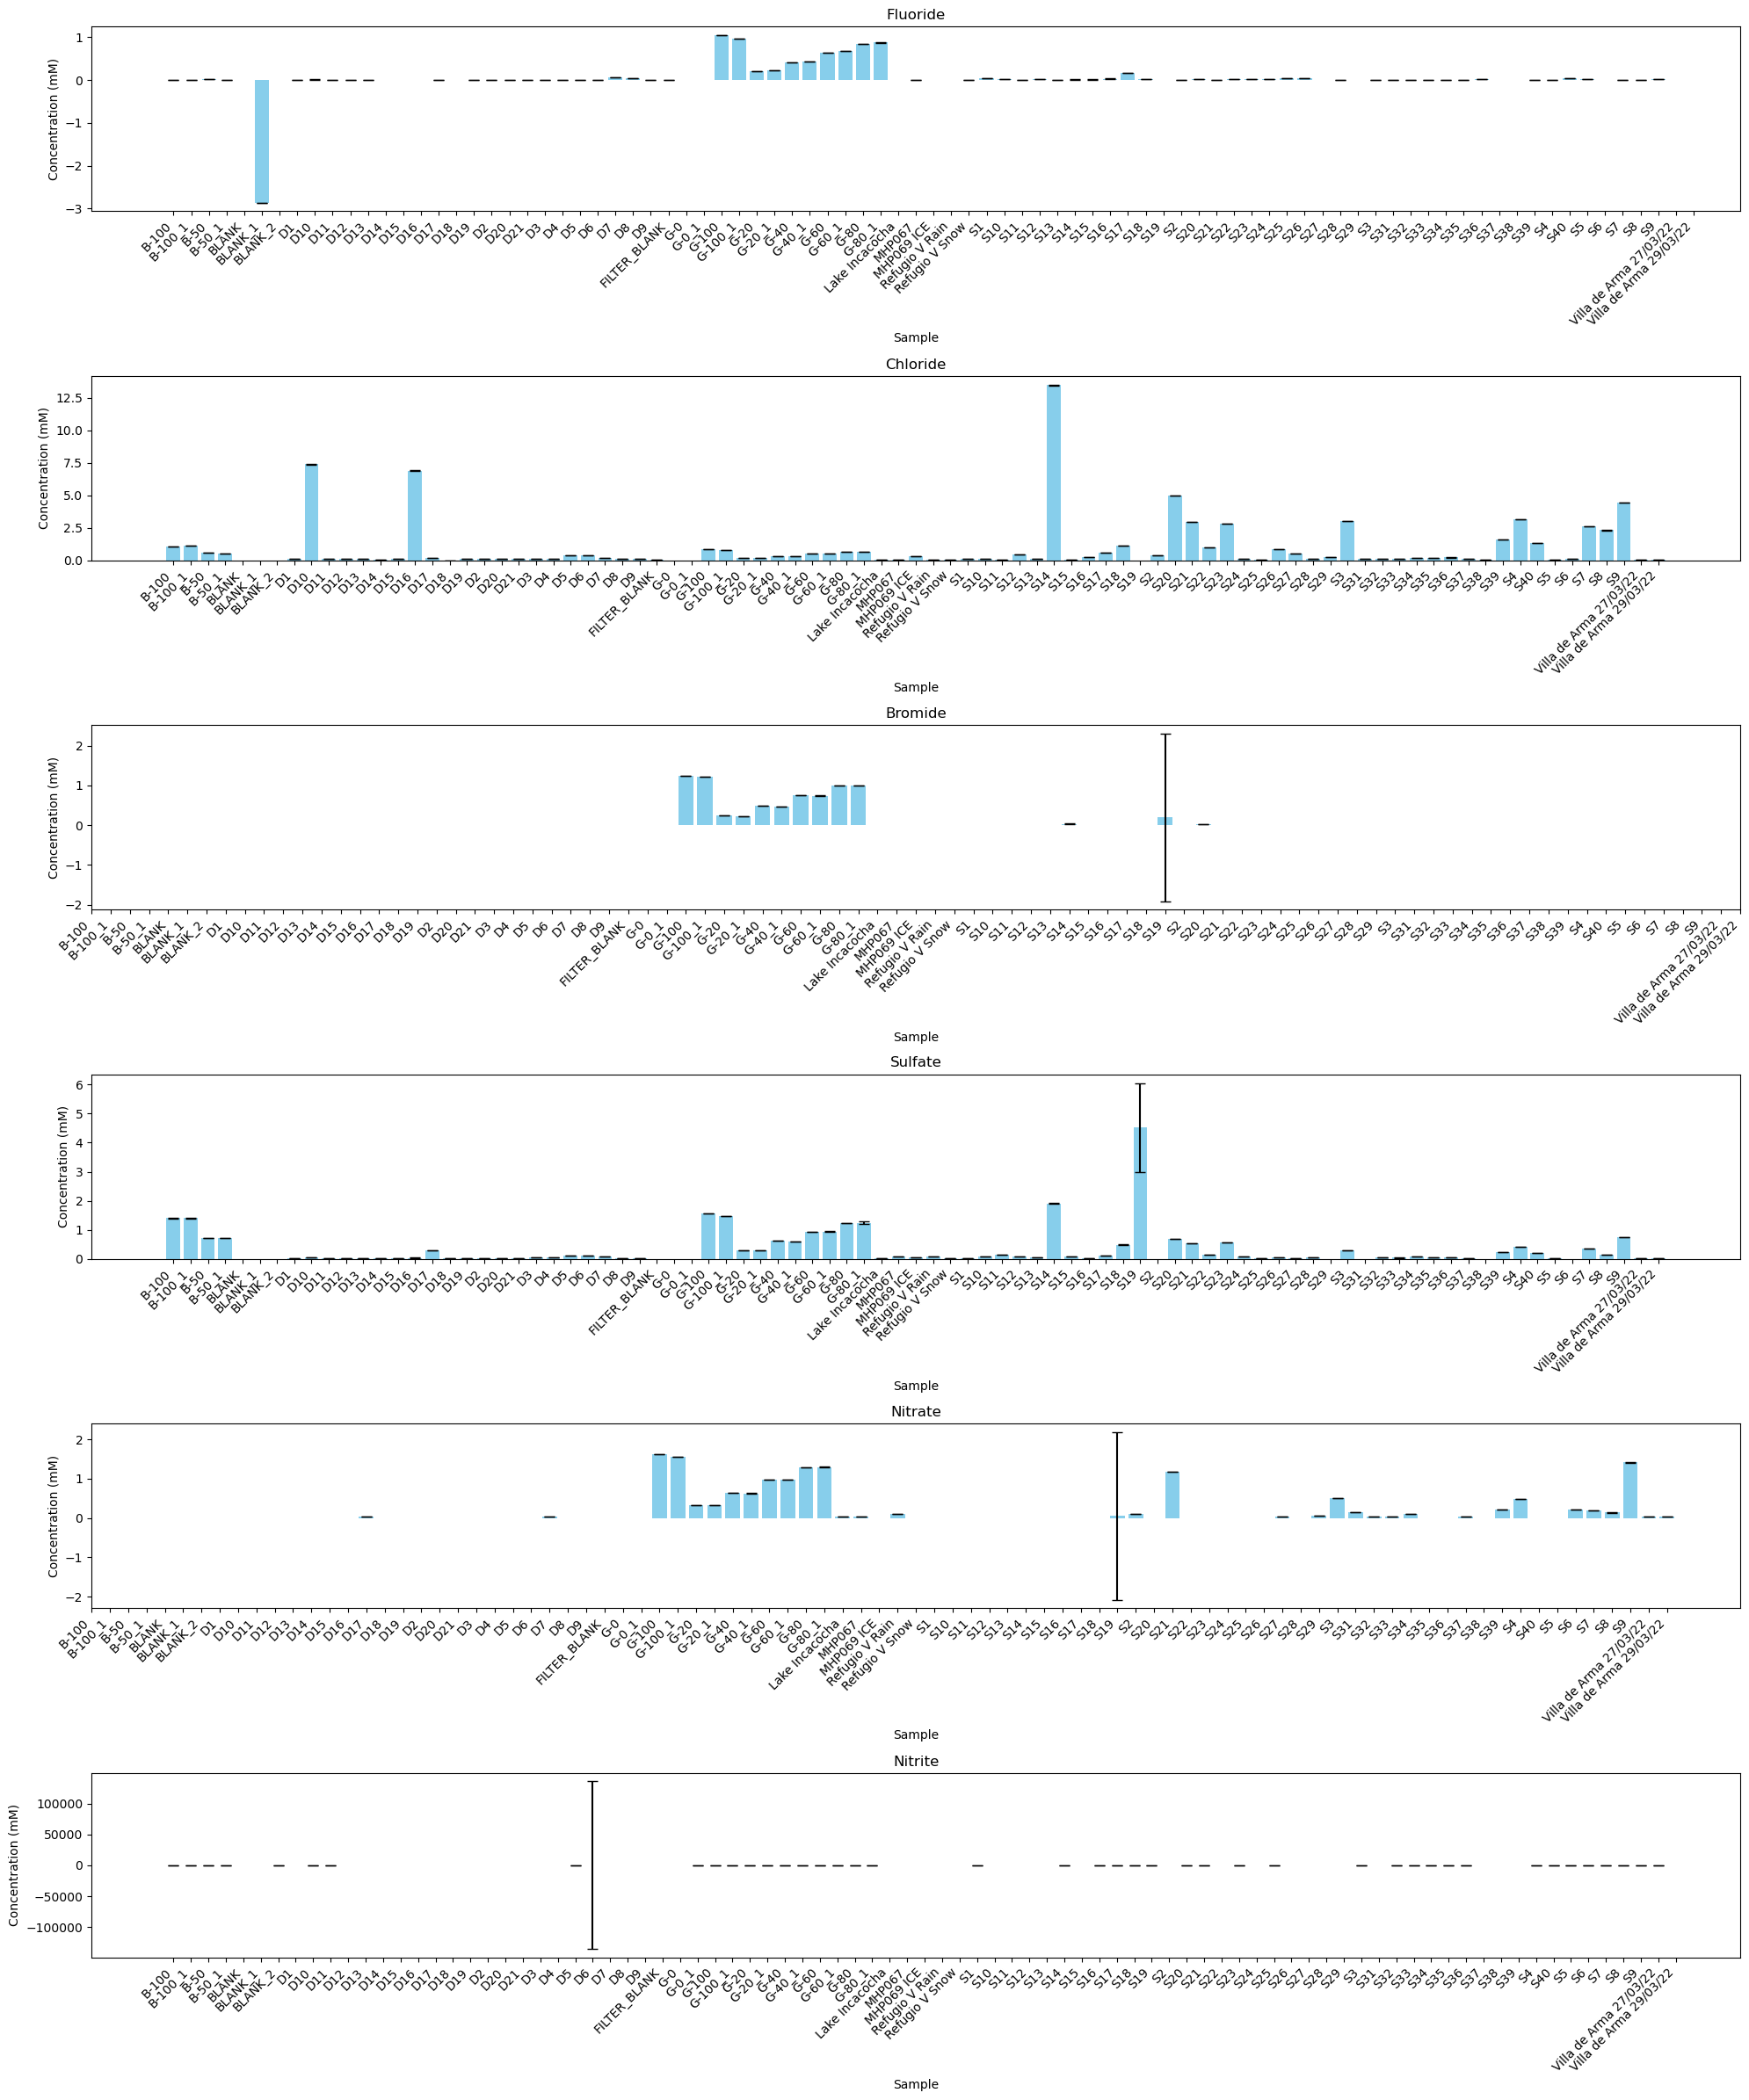

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_species_concentrations_bar_subplots(ds, species_list=None, calib_standard_samples=None):
    """
    Plots a separate bar chart (with error bars) for each analyte based on the 
    computed "concentration" and "concentration_error" in the dataset. For each analyte (taken 
    from ds["peak_identity"] if species_list is None, otherwise using species_list), the function:
    
      - Iterates over the selected samples (if calib_standard_samples is provided, only those samples are used)
      - For each sample, it looks for the first occurrence of the analyte in ds["peak_identity"]
      - If found, it extracts the corresponding "concentration" and "concentration_error"
      - Samples where the analyte is missing are skipped for that analyte.
    
    Each analyte is plotted on its own subplot (one axis per analyte) with the sample names on the x‑axis.
    This version creates independent x‐axes (i.e. not shared) so that tick labels appear on every subplot.
    
    Parameters:
      ds (xr.Dataset): Dataset containing:
           - "peak_identity" (dims: sample x peak): assigned analyte names for each peak.
           - "concentration" (dims: sample x peak): computed concentration (mM).
           - "concentration_error" (dims: sample x peak): estimated uncertainty in concentration.
           - A coordinate "sample" with sample names.
      species_list (list, optional): List of analyte names to plot. If None, all unique non-empty species 
                                     from ds["peak_identity"] are used.
      calib_standard_samples (list or tuple, optional): If provided, only samples whose names are in this list 
                                     will be plotted; otherwise, all samples in ds["sample"] are used.
    
    Returns:
      None. Displays a figure with one subplot per analyte.
    """
    # Determine samples to use.
    if calib_standard_samples is not None:
        samples = [s for s in ds["sample"].values if s in calib_standard_samples]
    else:
        samples = ds["sample"].values
    n_samples = len(samples)
    
    # Determine species to plot.
    if species_list is None:
        all_species = ds["peak_identity"].values.flatten()
        unique_species = np.unique([s for s in all_species if s != "" and not pd.isna(s)])
    else:
        unique_species = species_list
    unique_species = list(unique_species)
    n_species = len(unique_species)
    
    # Create subplots with independent x-axes so every subplot has tick labels.
    fig, axes = plt.subplots(n_species, 1, figsize=(20, 4*n_species), sharex=False)
    if n_species == 1:
        axes = [axes]
    
    # Loop over each species.
    for idx, species in enumerate(unique_species):
        ax = axes[idx]
        sample_indices = []
        conc_values = []
        err_values = []
        for i, sample in enumerate(samples):
            sample_peak_ids = ds["peak_identity"].sel(sample=sample).values
            match_indices = np.where(sample_peak_ids == species)[0]
            if match_indices.size == 0:
                continue  # species missing in this sample.
            j = match_indices[0]
            conc_val = ds["concentration"].sel(sample=sample).values[j]
            err_val = ds["concentration_error"].sel(sample=sample).values[j]
            if np.isnan(conc_val):
                continue
            sample_indices.append(i)
            conc_values.append(conc_val)
            err_values.append(err_val if not np.isnan(err_val) else 0.0)
        if len(sample_indices) == 0:
            ax.text(0.5, 0.5, f"No data for {species}", transform=ax.transAxes,
                    ha="center", va="center")
            ax.set_title(species)
            ax.set_xlabel("Sample")
            continue
        ax.bar(sample_indices, conc_values, yerr=err_values, capsize=4, color='skyblue')
        ax.set_title(species)
        ax.set_ylabel("Concentration (mM)")
        ax.set_xticks(np.arange(n_samples))
        ax.set_xticklabels(samples, rotation=45, ha="right")
        ax.set_xlabel("Sample")
    
    plt.tight_layout()
    plt.show()

# Example usage:
species_to_plot = ["Fluoride", "Chloride", "Bromide", "Sulfate", "Nitrate", "Nitrite"]
plot_species_concentrations_bar_subplots(ds, species_list=species_to_plot, calib_standard_samples=None)


In [6]:
import numpy as np
import pandas as pd

def compare_to_reference(ds, reference_sample):
    """
    For each sample in the dataset (excluding the reference sample), compares the computed concentration 
    for each peak to that in the reference sample using the "peak_identity" variable for matching.
    
    For each sample, the function:
      - Constructs a reference dictionary for the reference_sample mapping each analyte (after stripping) 
        from ds["peak_identity"] to its corresponding concentration (from ds["concentration"]). Only the 
        first occurrence of an analyte in the reference is used.
      - For each peak in the sample, if its analyte (after stripping) is found in the reference dictionary, 
        computes the ratio: (sample concentration) / (reference concentration).
      - Among those analytes with ratio > 1, identifies the analyte with the highest ratio and prints its name 
        and ratio. It also prints a list of any other analytes in that sample with concentrations greater than 
        in the reference sample (without their ratio).
    
    Parameters:
      ds (xr.Dataset): Dataset containing:
           - "peak_identity" (dims: sample x peak): assigned analyte names for each peak.
           - "concentration" (dims: sample x peak): computed concentration (mM) for each peak.
           - A coordinate "sample" containing sample names.
      reference_sample (str): The sample name to use as the reference.
    
    Returns:
      dict: A dictionary mapping each sample (other than the reference) to a tuple:
            (max_analyte, max_ratio, list_of_other_analytes)
    """
    # Build the reference dictionary from the reference sample.
    ref_ids = ds["peak_identity"].sel(sample=reference_sample).values
    ref_conc = ds["concentration"].sel(sample=reference_sample).values
    ref_dict = {}
    for j, analyte in enumerate(ref_ids):
        if analyte and not pd.isna(analyte):
            # Use the stripped analyte name as key.
            key = analyte.strip()
            # Only use the first occurrence.
            if key not in ref_dict and ref_conc[j] != 0 and not np.isnan(ref_conc[j]):
                ref_dict[key] = ref_conc[j]
    
    if not ref_dict:
        raise ValueError(f"No valid analyte concentrations found in reference sample '{reference_sample}'.")
    
    results = {}
    all_samples = ds["sample"].values
    for sample in all_samples:
        if sample == reference_sample:
            continue  # skip the reference sample
        # Build a dictionary for this sample: analyte (stripped) -> concentration, using the first occurrence.
        sample_ids = ds["peak_identity"].sel(sample=sample).values
        sample_conc = ds["concentration"].sel(sample=sample).values
        sample_dict = {}
        for j, analyte in enumerate(sample_ids):
            if analyte and not pd.isna(analyte):
                key = analyte.strip()
                # Only take the first occurrence if not already added.
                if key not in sample_dict and sample_conc[j] != 0 and not np.isnan(sample_conc[j]):
                    sample_dict[key] = sample_conc[j]
        
        # Now compare each analyte that exists in both dictionaries.
        ratios = {}
        for analyte, conc in sample_dict.items():
            if analyte in ref_dict:
                ref_value = ref_dict[analyte]
                ratio = conc / ref_value
                if ratio > 1:
                    ratios[analyte] = ratio
        if not ratios:
            #print(f"Sample '{sample}': No analyte has a concentration greater than in the reference sample '{reference_sample}'.")
            results[sample] = (None, None, [])
        else:
            # Find the analyte with the maximum ratio.
            max_analyte = max(ratios, key=ratios.get)
            max_ratio = ratios[max_analyte]
            # List other analytes (exclude the maximum one).
            other_analytes = [a for a in ratios if a != max_analyte]
            print(f"Sample '{sample}': Highest: {max_analyte} (ratio: {max_ratio:.2f}); Other analytes above reference: {other_analytes}")
            results[sample] = (max_analyte, max_ratio, other_analytes)
    
    return results

# Example usage:
# Suppose our reference sample is 'G-100'
results = compare_to_reference(ds, reference_sample='G-100')
print(results)


Sample 'B-100': Highest: Chloride (ratio: 1.28); Other analytes above reference: []
Sample 'B-100_1': Highest: Chloride (ratio: 1.32); Other analytes above reference: []
Sample 'D10': Highest: Chloride (ratio: 8.73); Other analytes above reference: []
Sample 'D16': Highest: Chloride (ratio: 8.15); Other analytes above reference: []
Sample 'S14': Highest: Chloride (ratio: 15.91); Other analytes above reference: ['Sulfate']
Sample 'S18': Highest: Chloride (ratio: 1.37); Other analytes above reference: []
Sample 'S19': Highest: Sulfate (ratio: 2.89); Other analytes above reference: []
Sample 'S20': Highest: Chloride (ratio: 5.87); Other analytes above reference: []
Sample 'S21': Highest: Chloride (ratio: 3.48); Other analytes above reference: []
Sample 'S22': Highest: Chloride (ratio: 1.18); Other analytes above reference: []
Sample 'S23': Highest: Chloride (ratio: 3.36); Other analytes above reference: []
Sample 'S26': Highest: Chloride (ratio: 1.01); Other analytes above reference: []
S

In [8]:
ds.sel(sample=['G-100'])['peak_retention_time'].values / 60

array([[3.393333, 4.623333, 5.52    , 6.433333, 7.233333, 8.353333]])

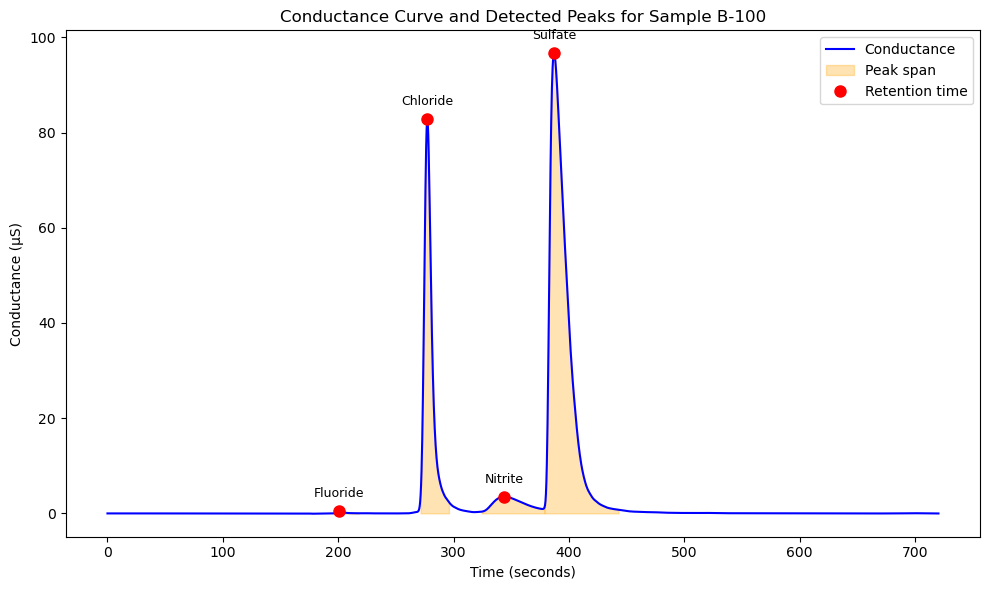

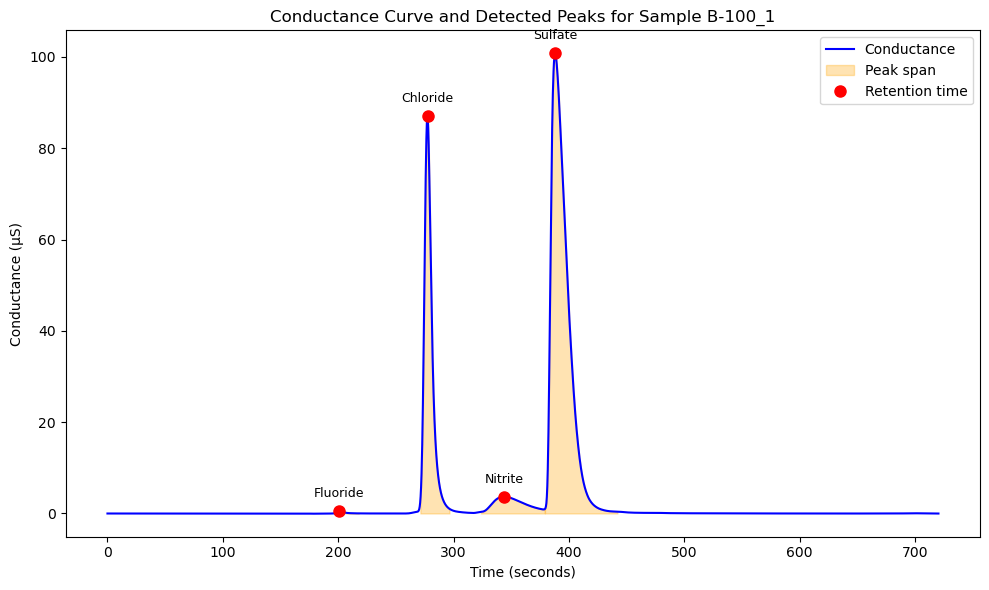

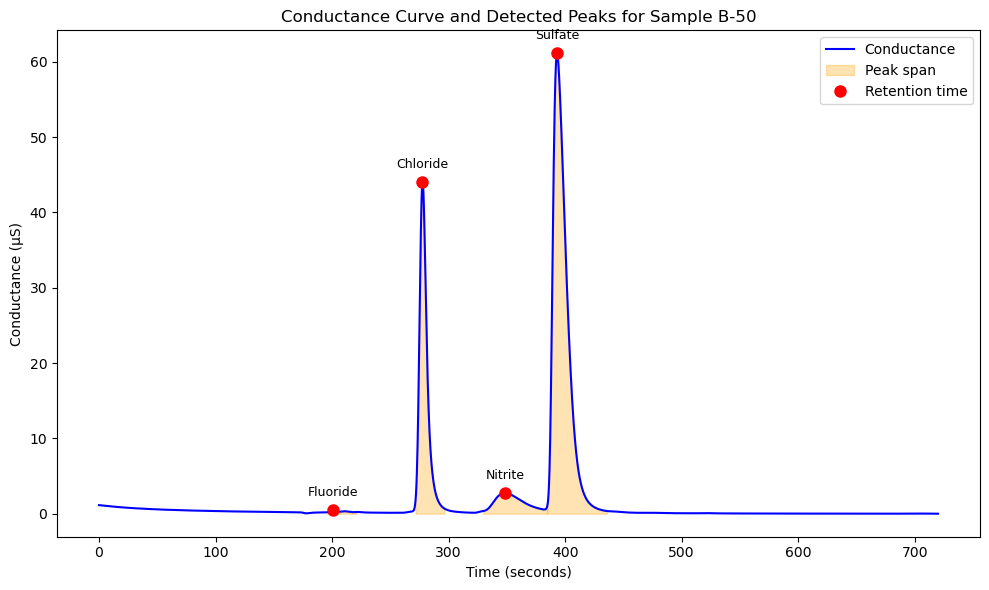

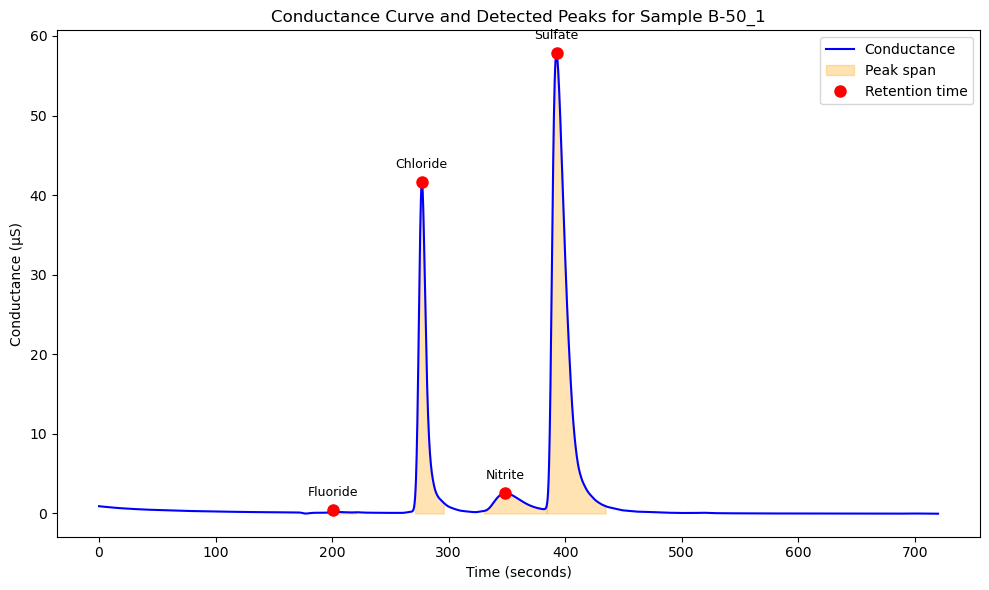

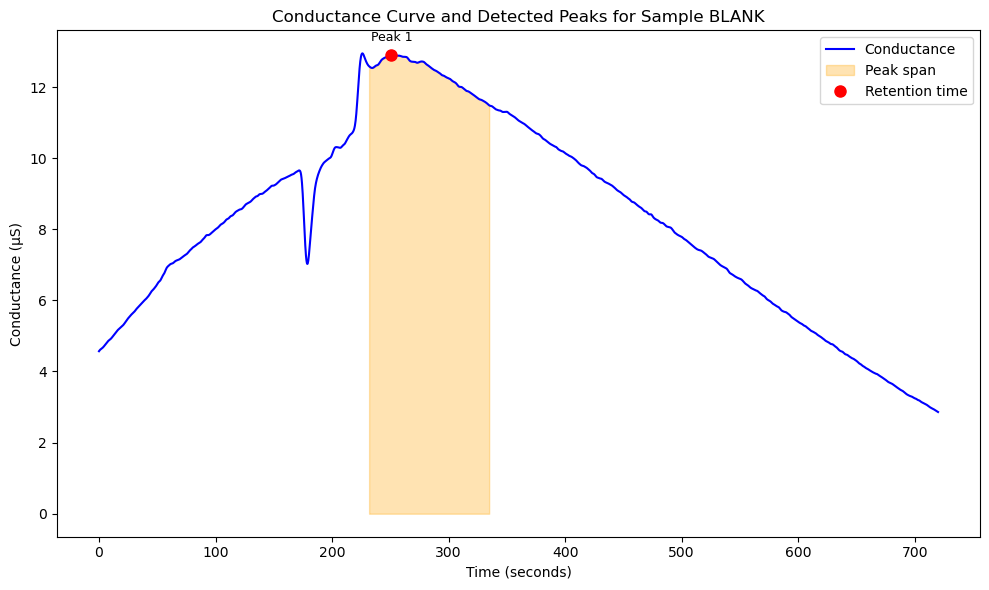

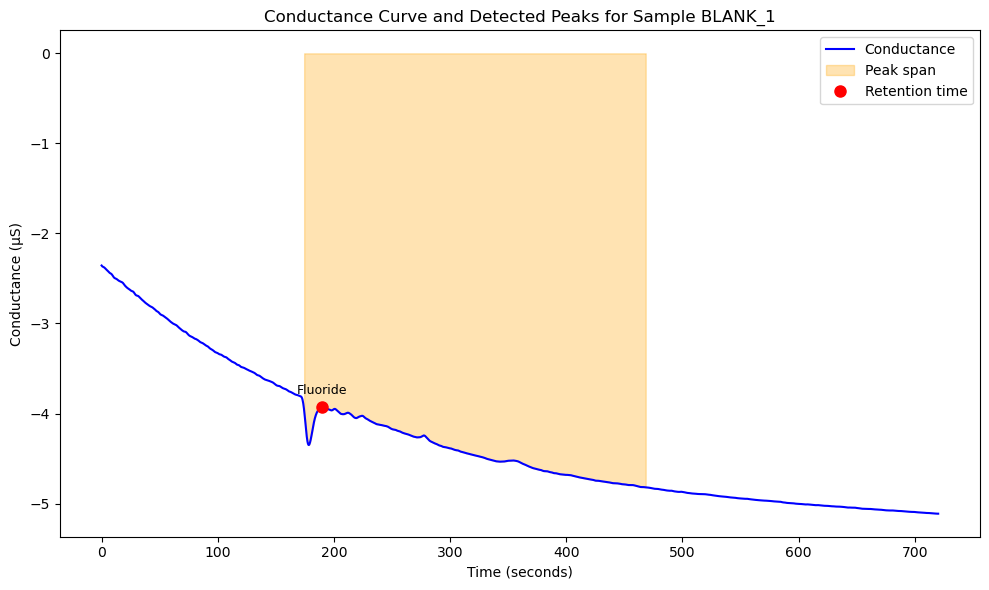

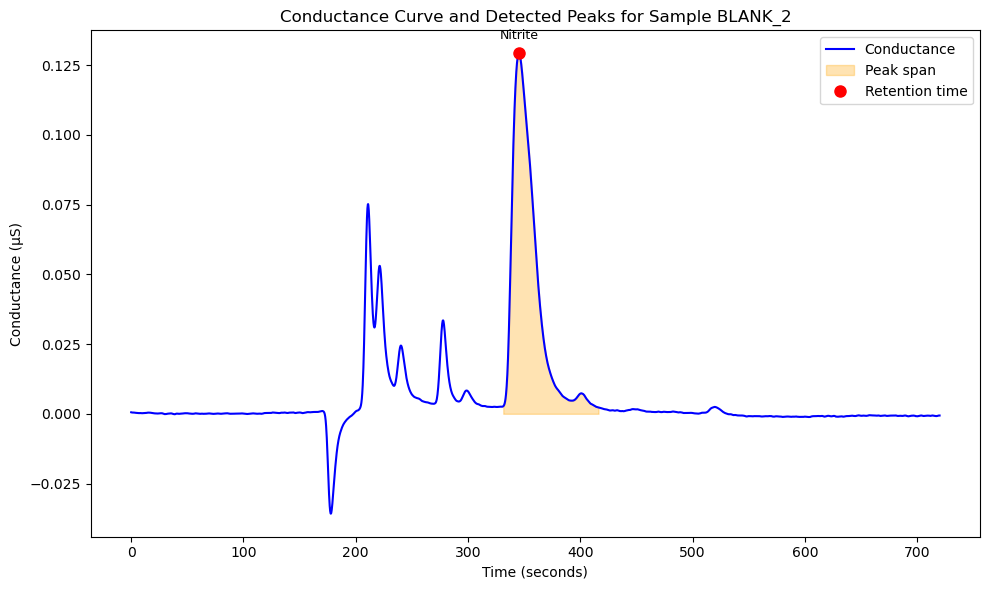

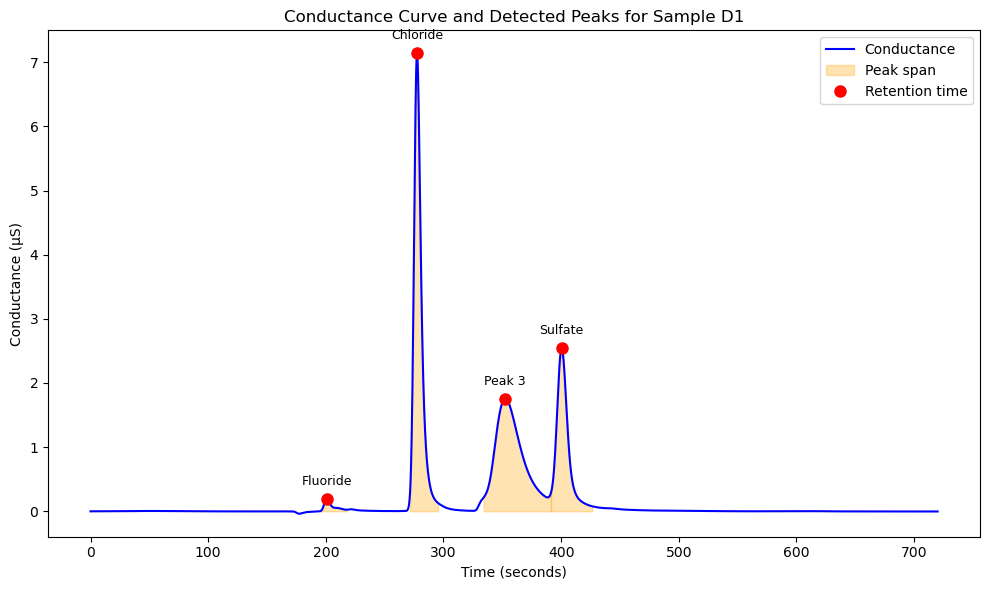

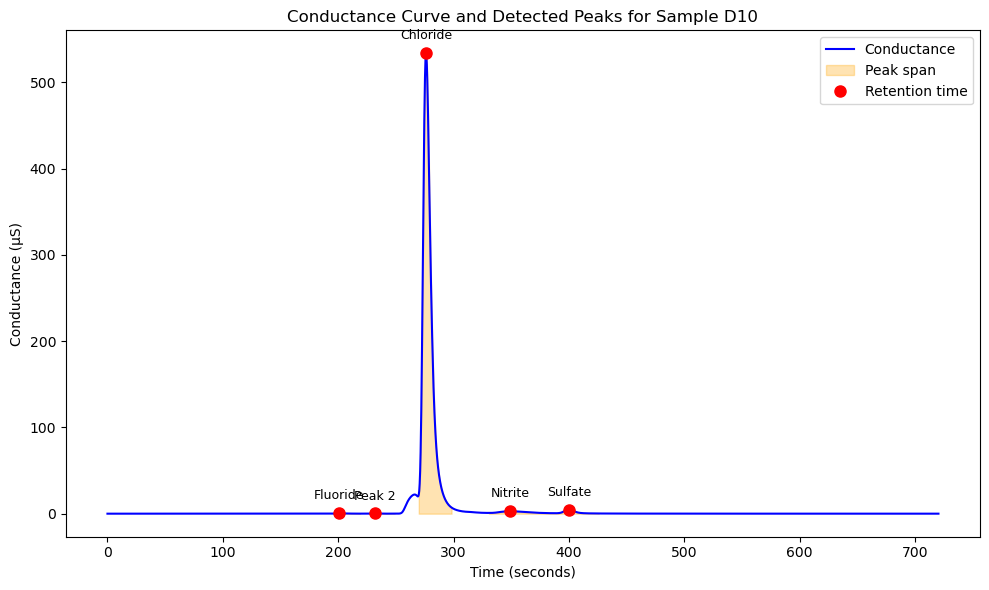

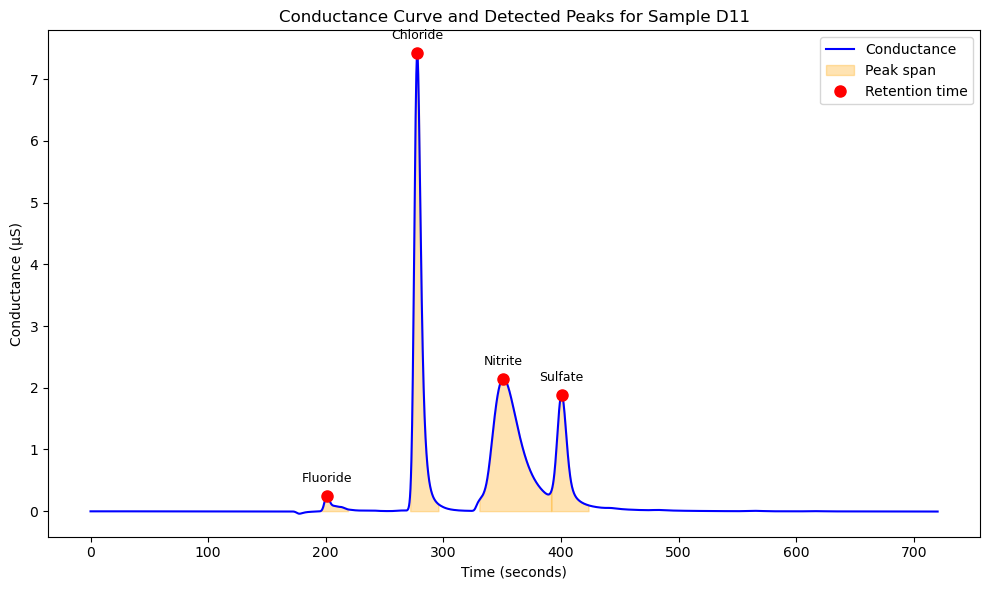

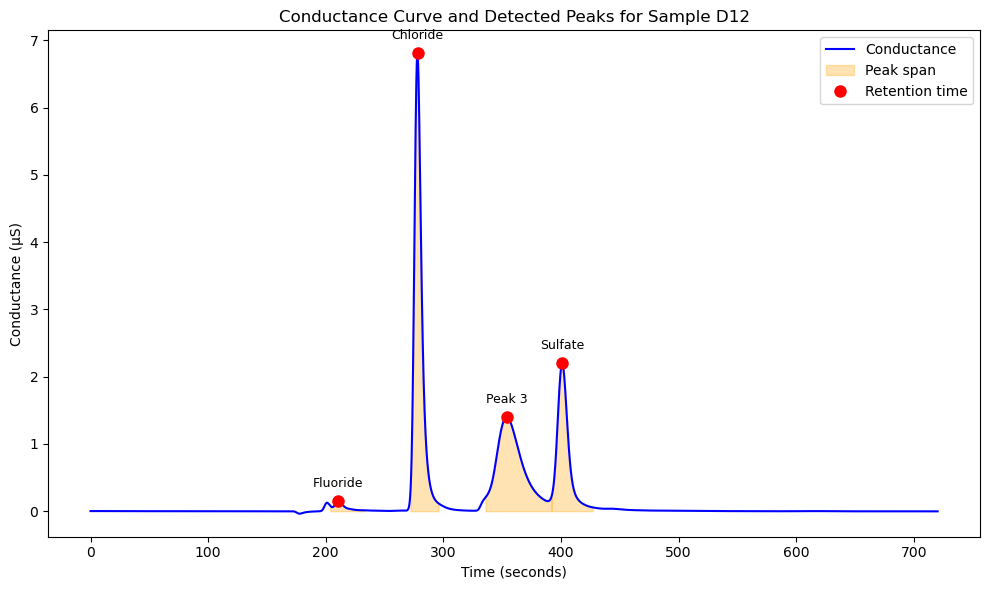

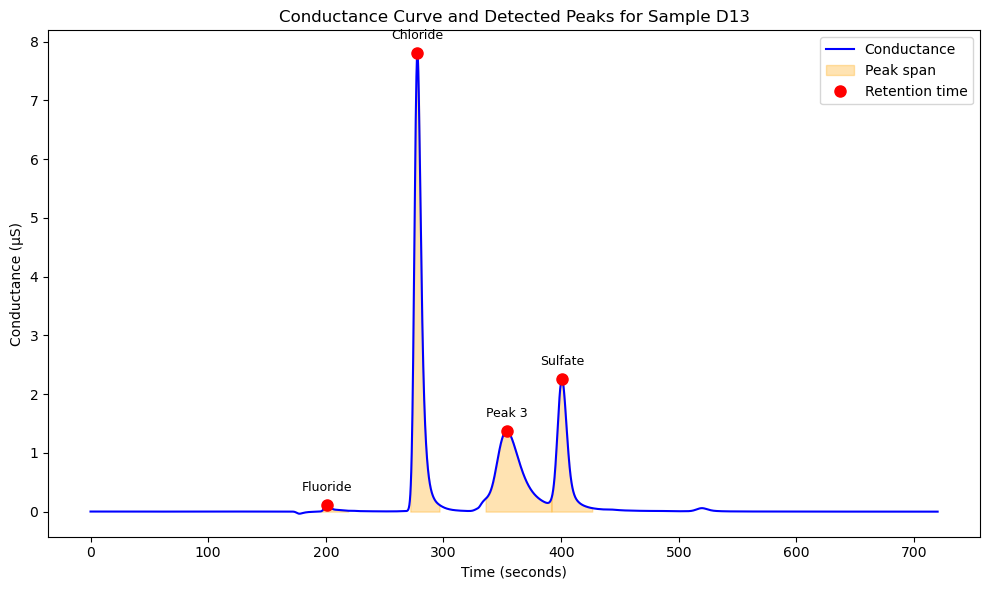

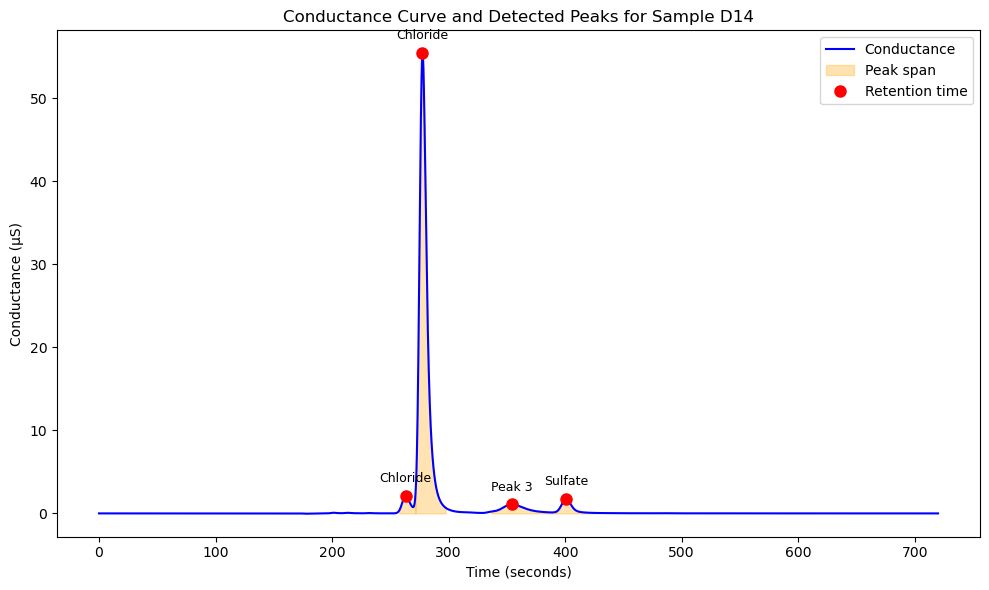

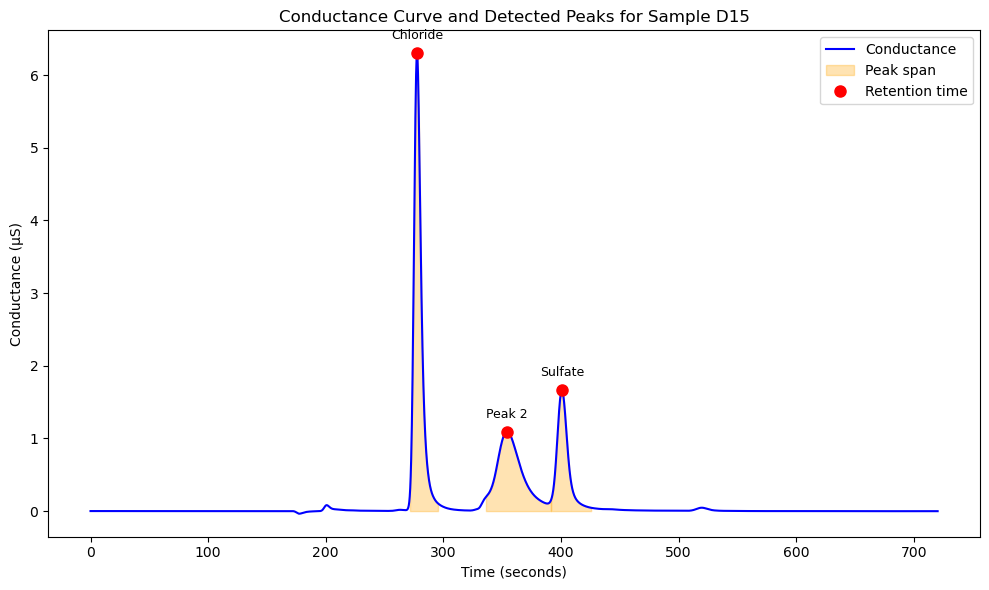

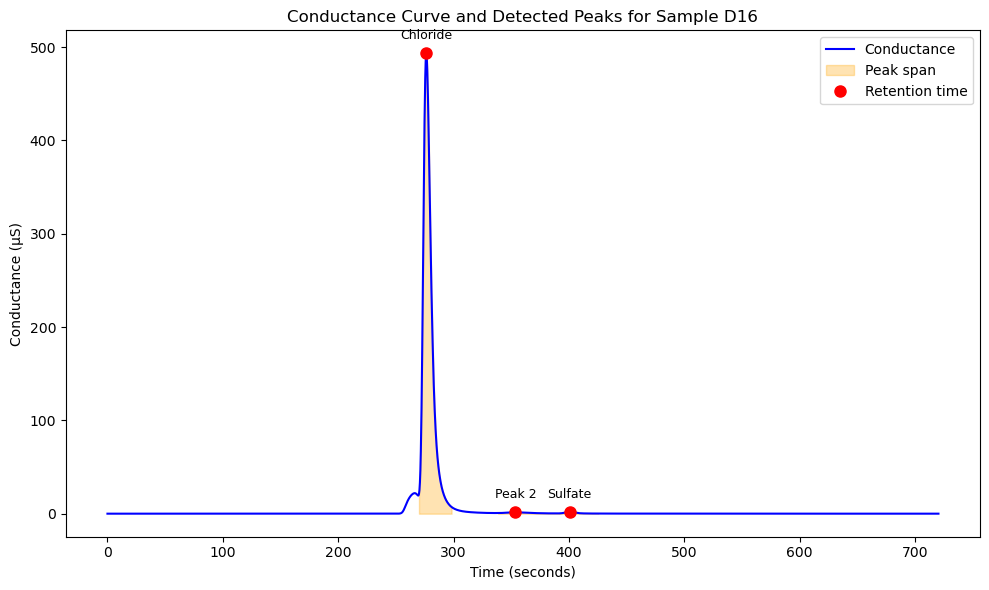

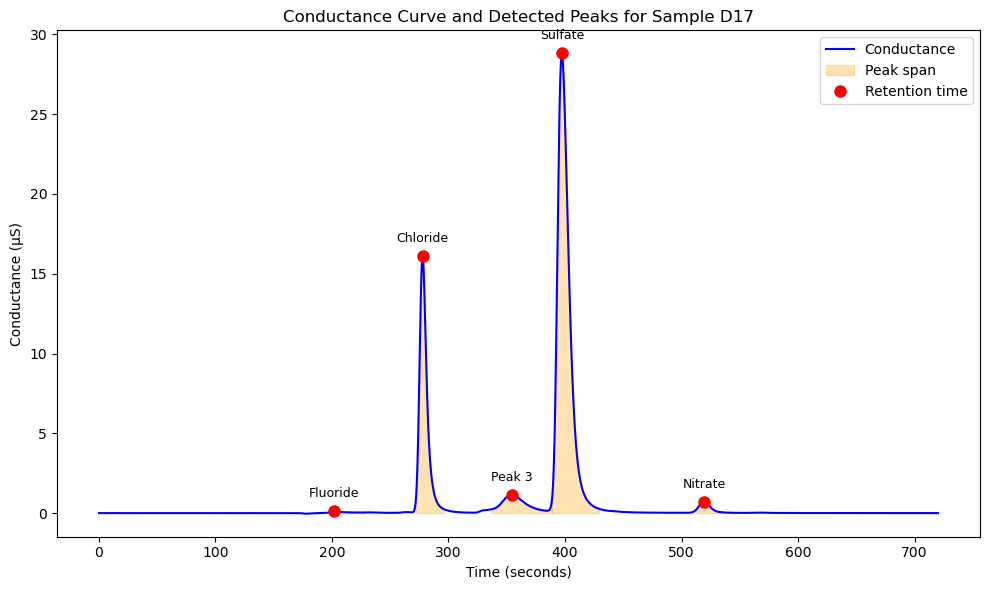

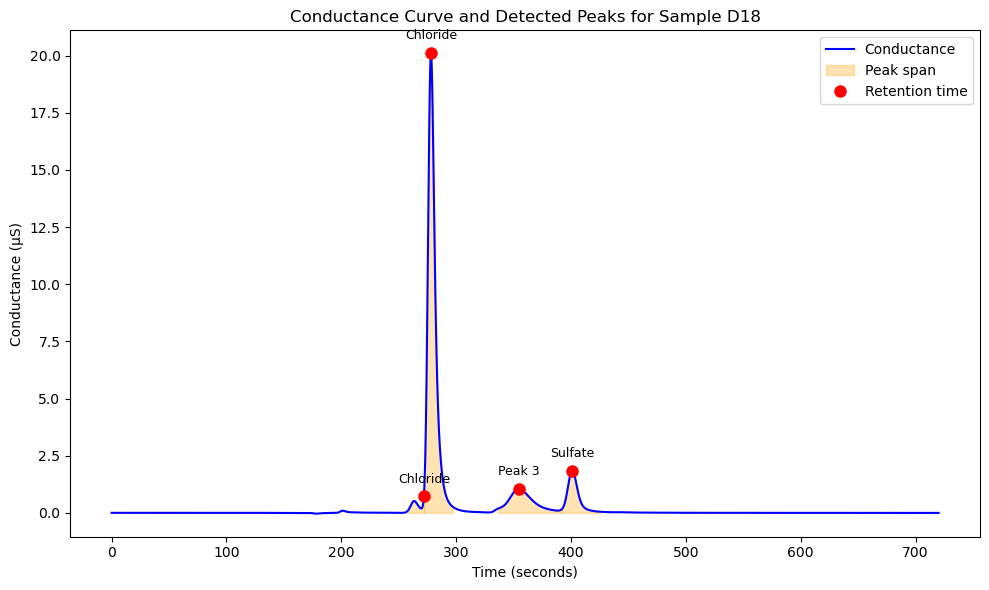

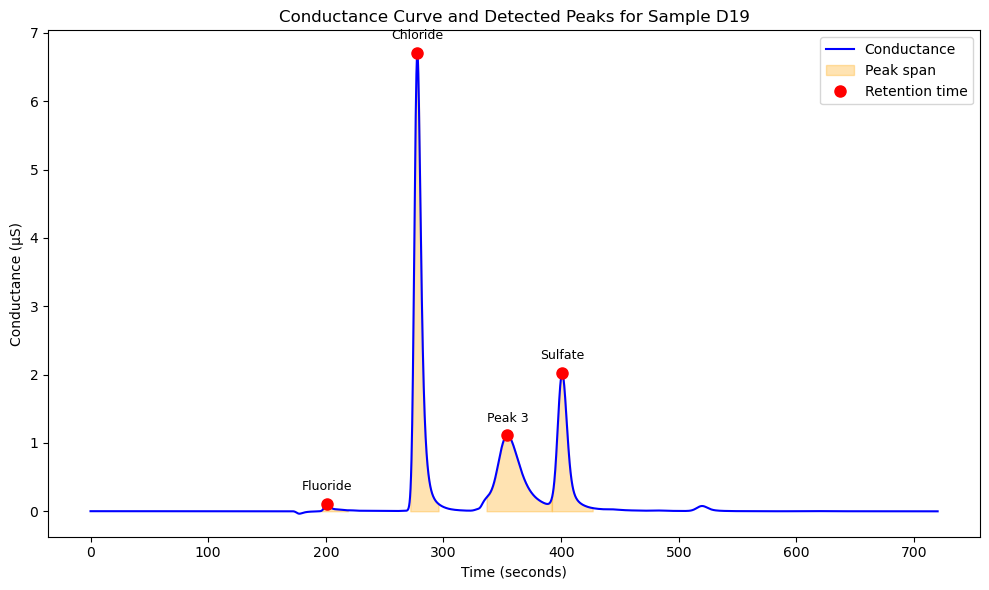

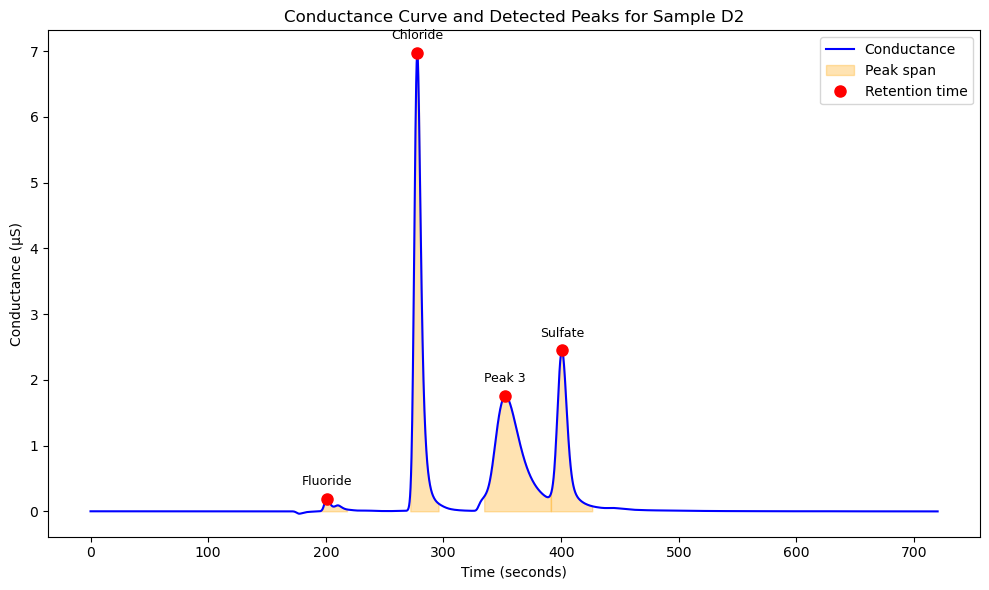

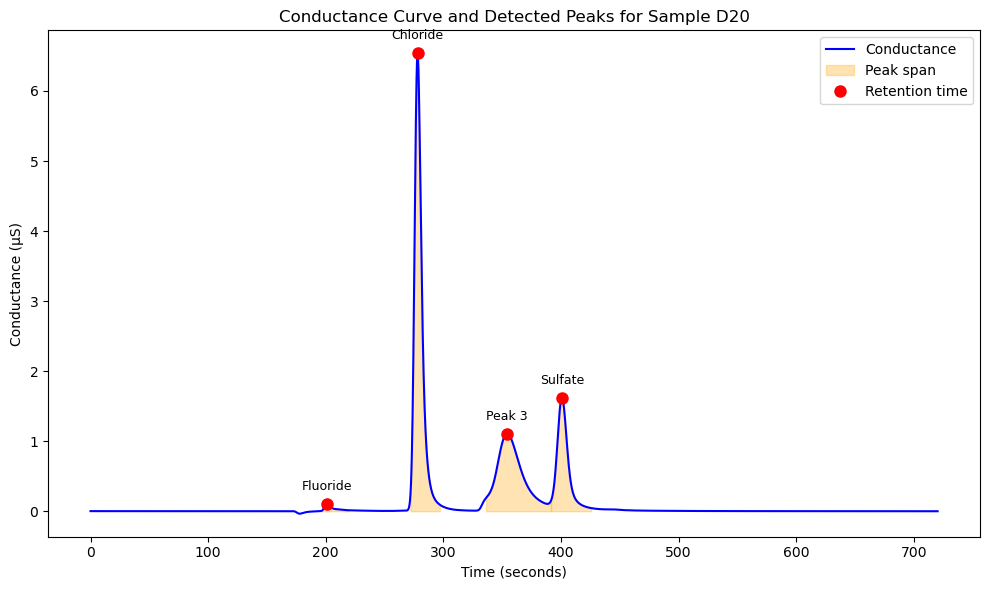

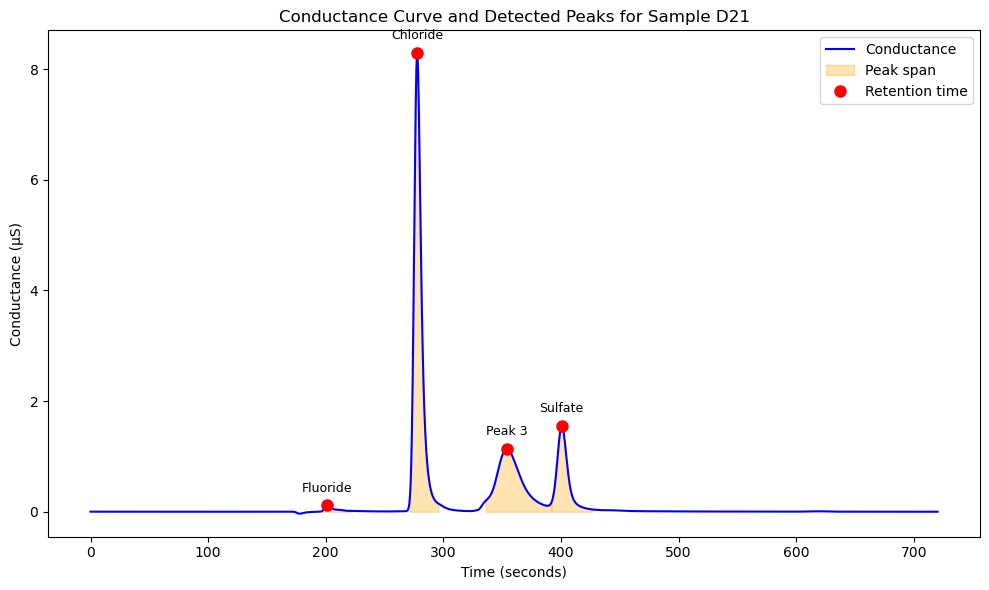

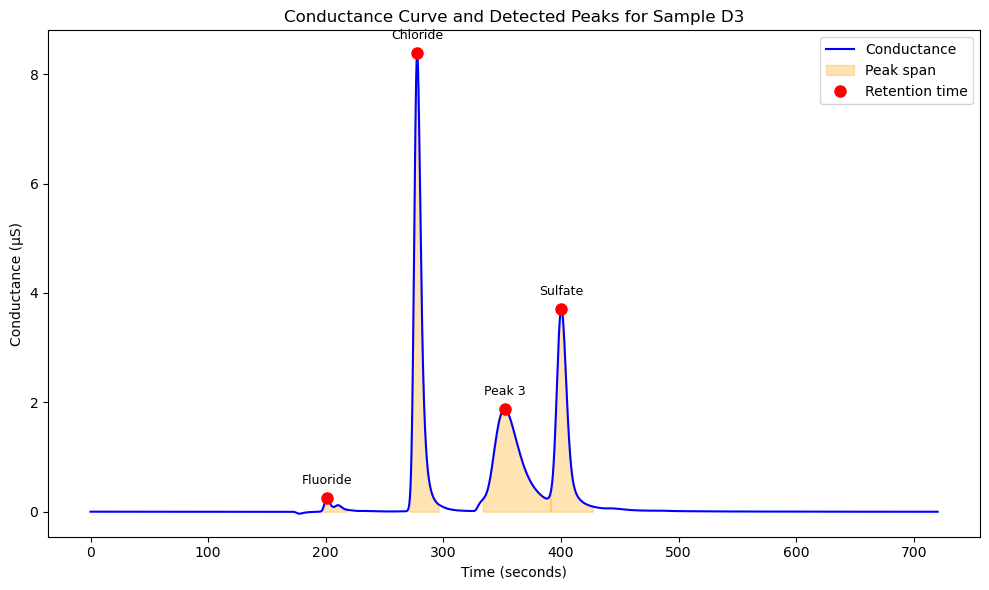

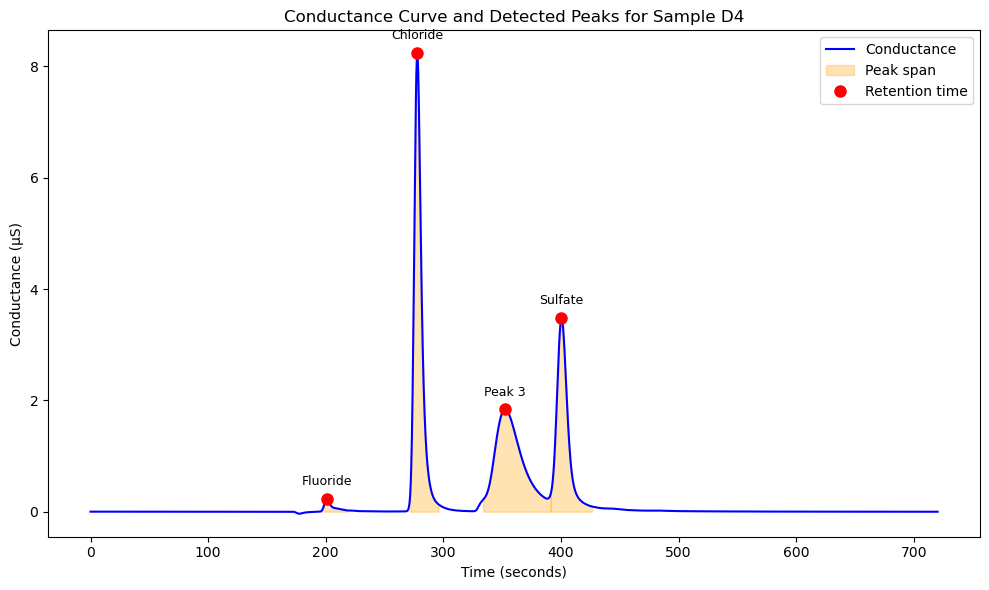

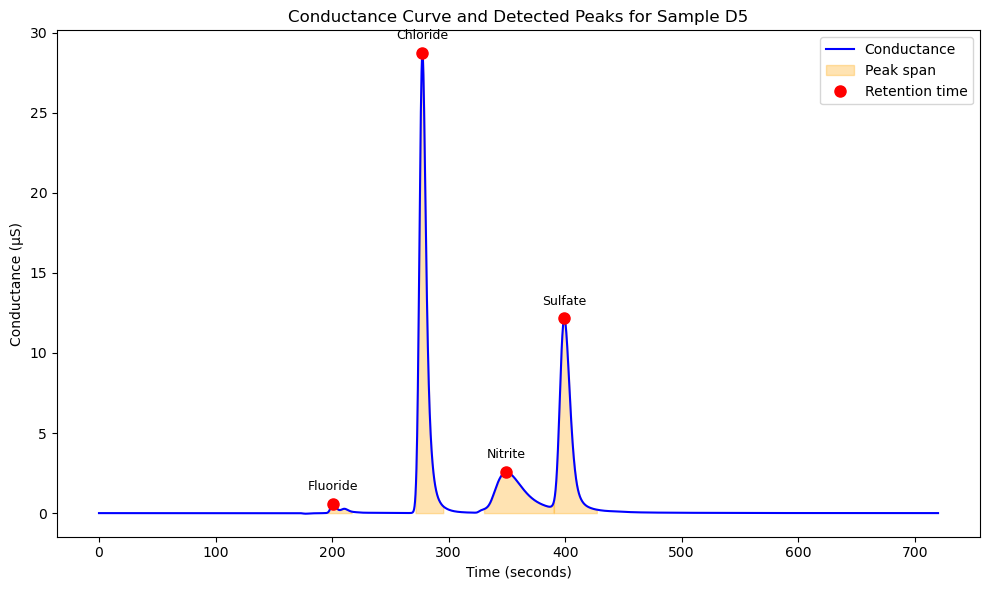

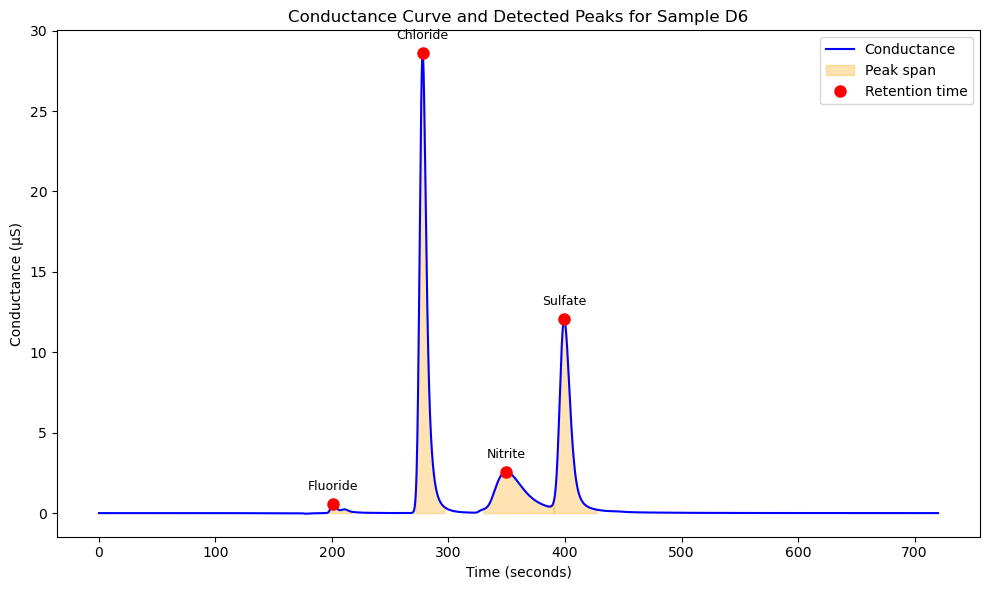

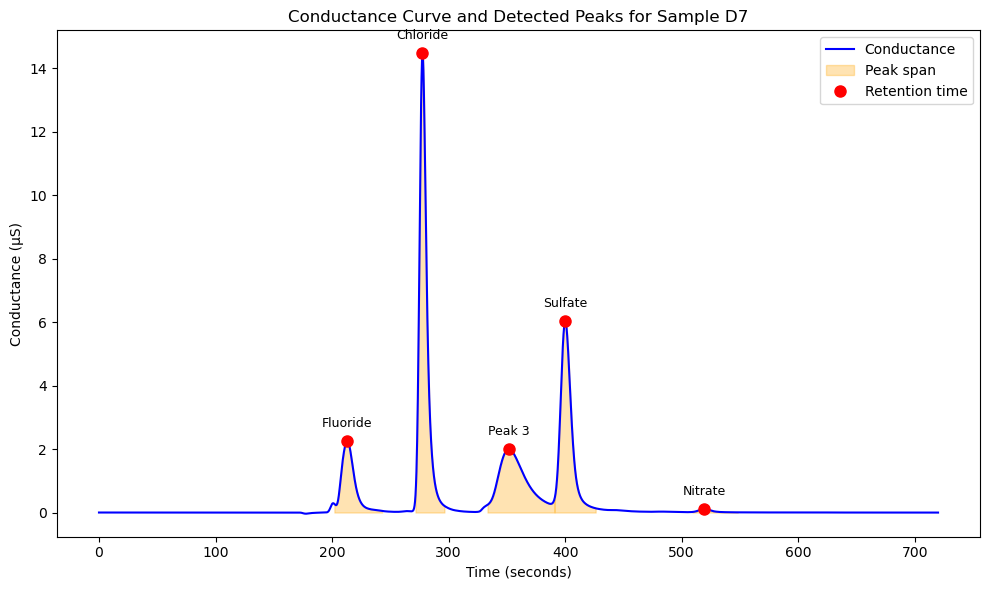

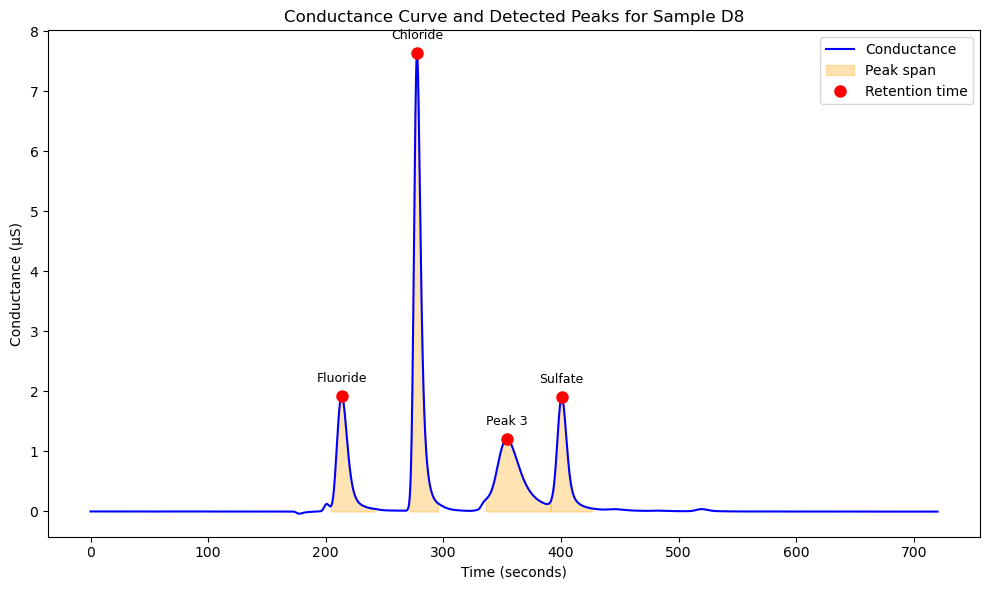

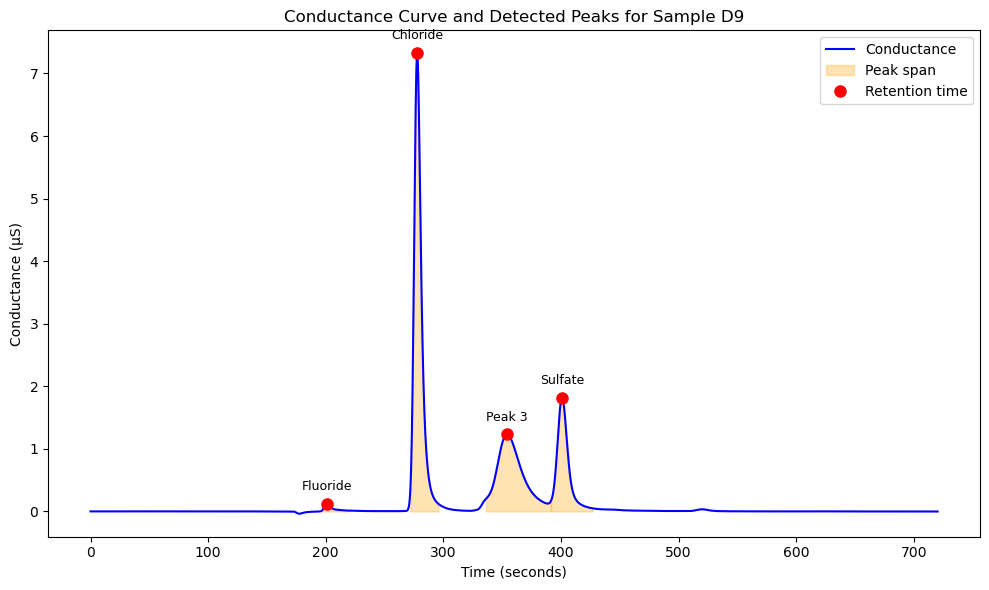

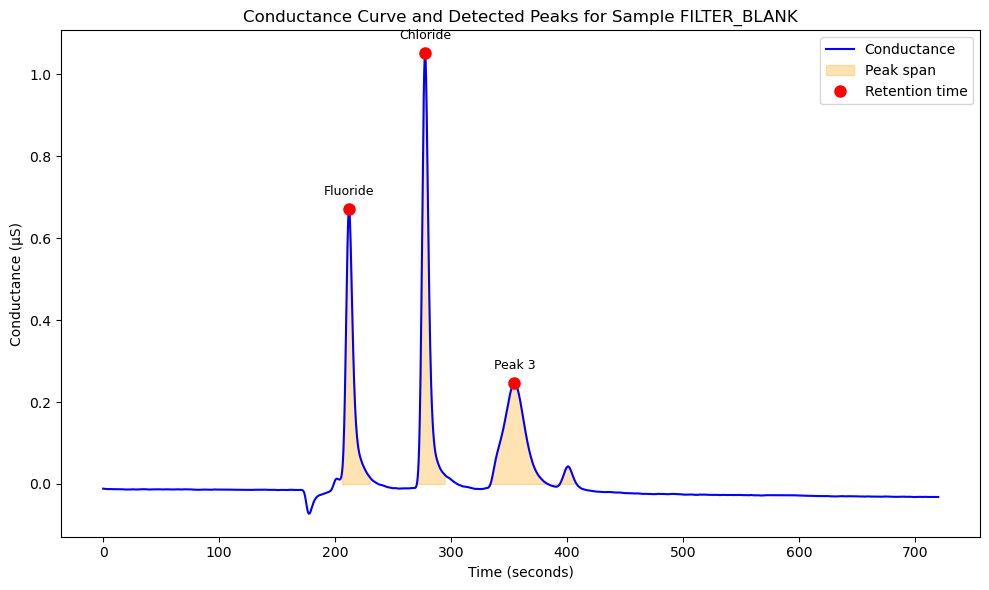

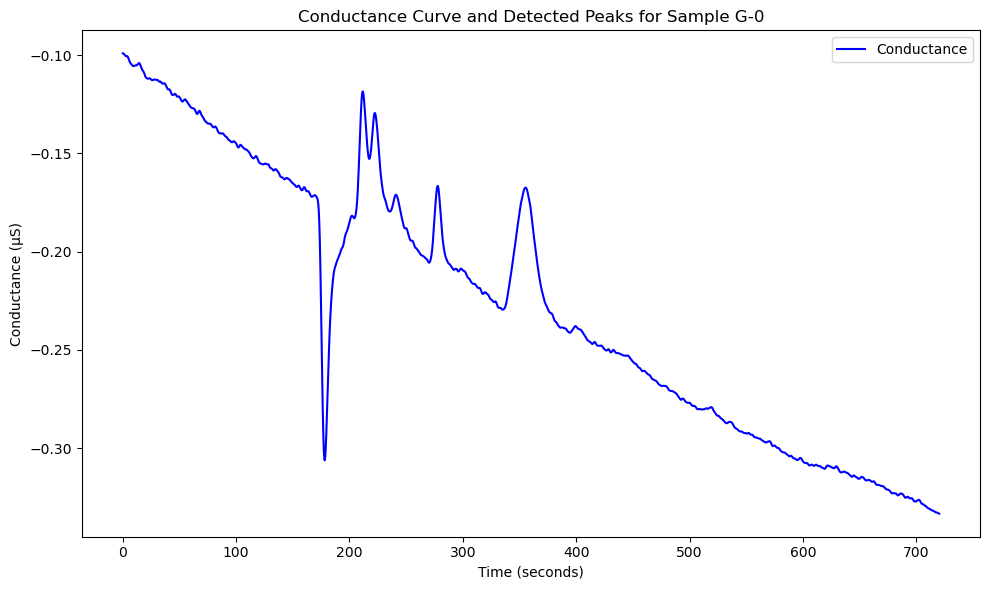

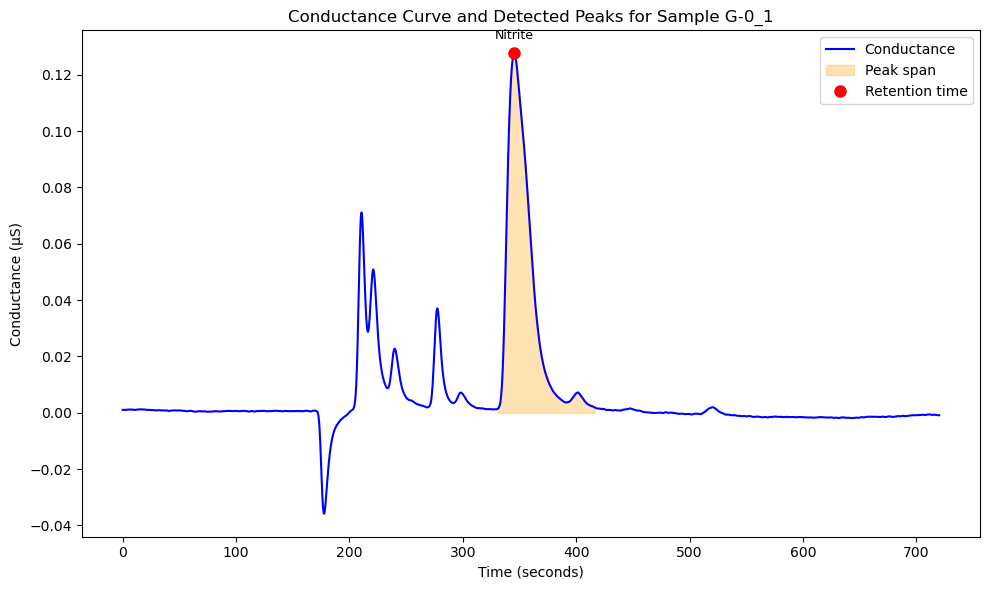

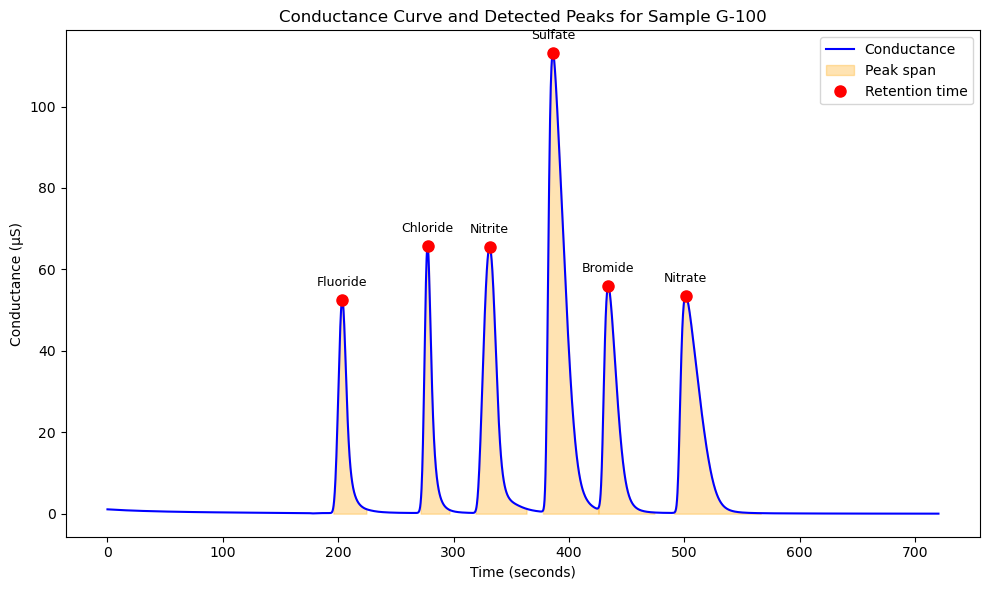

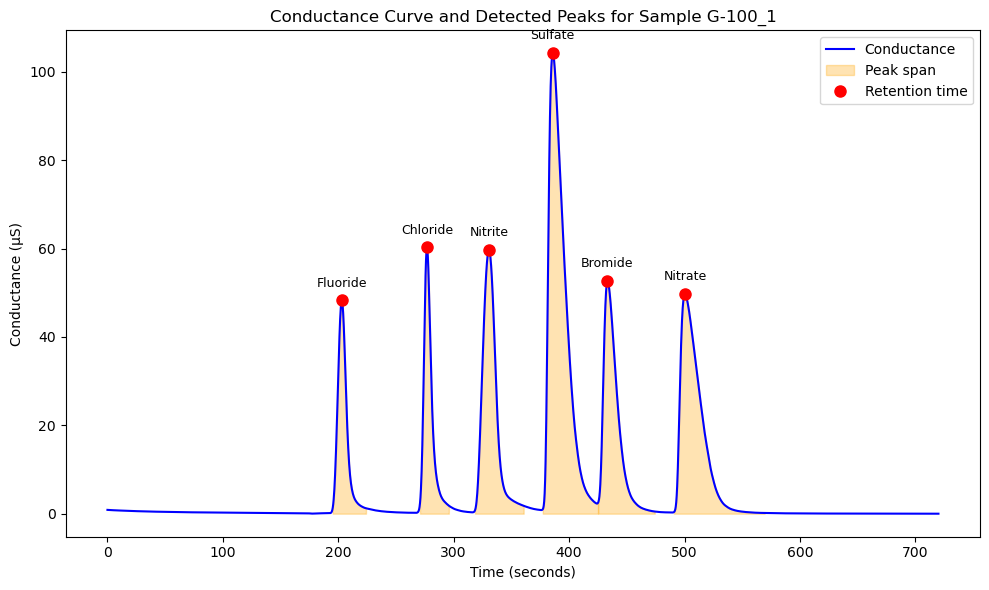

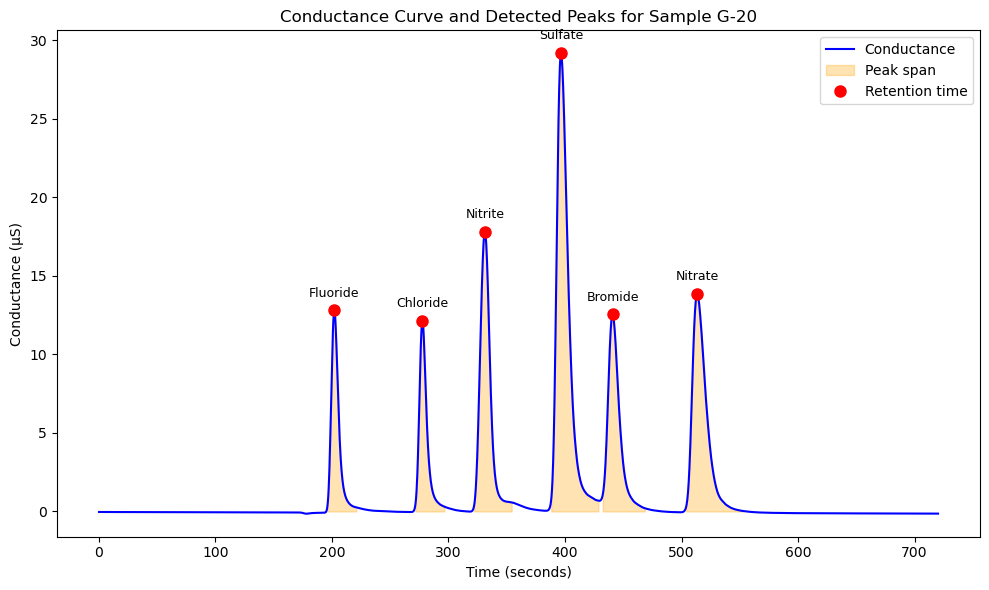

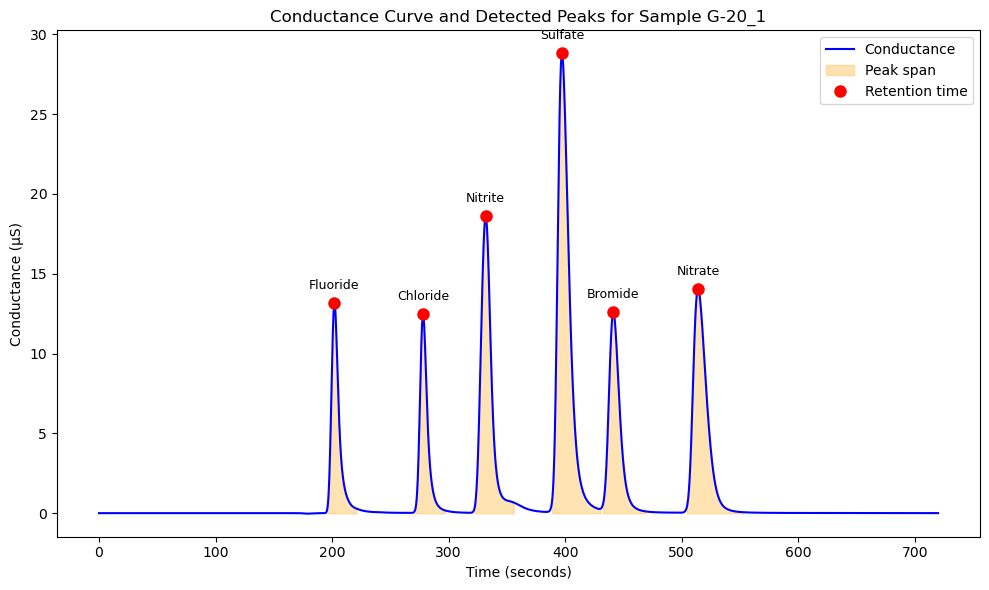

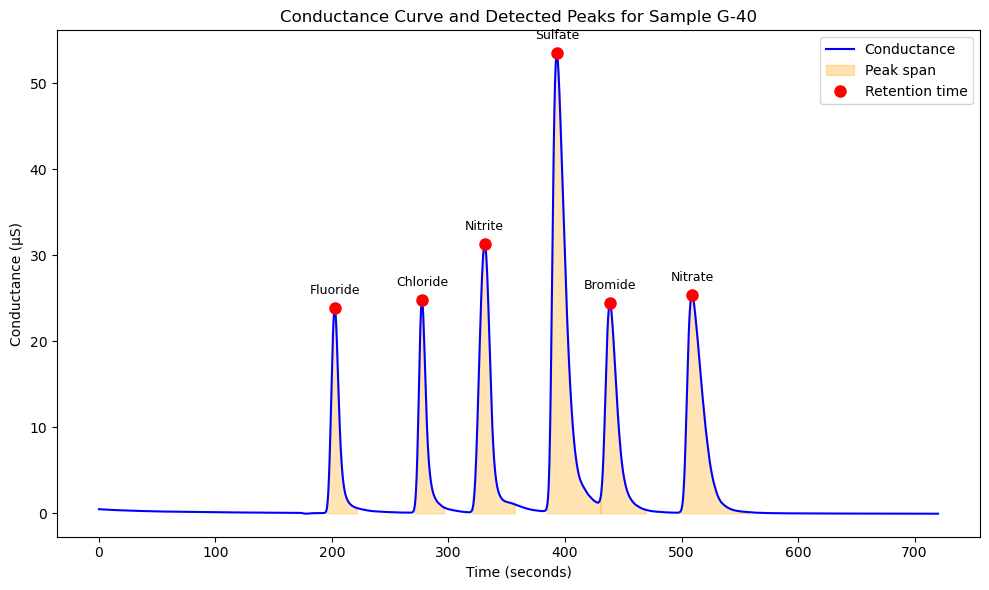

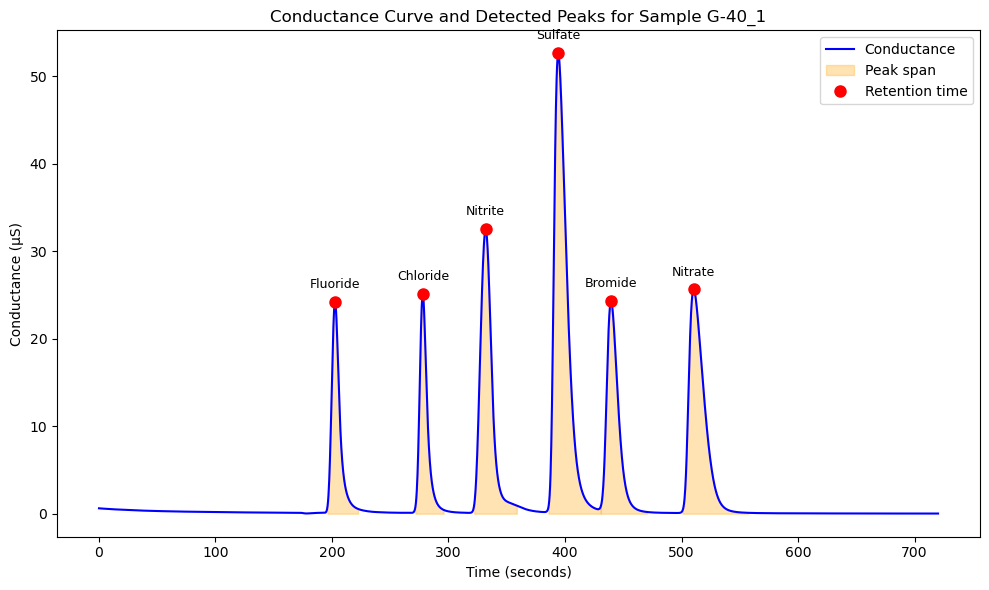

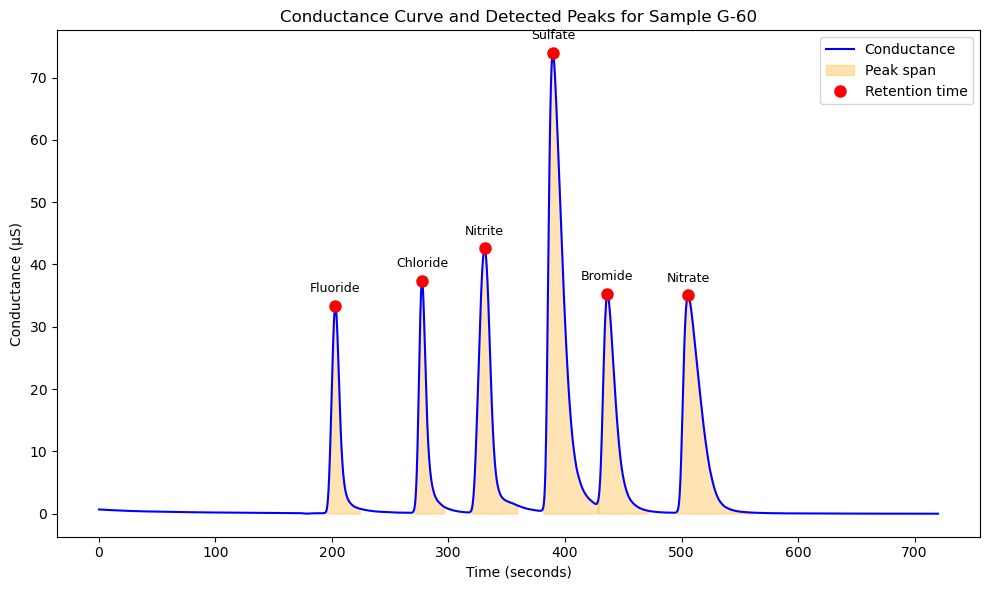

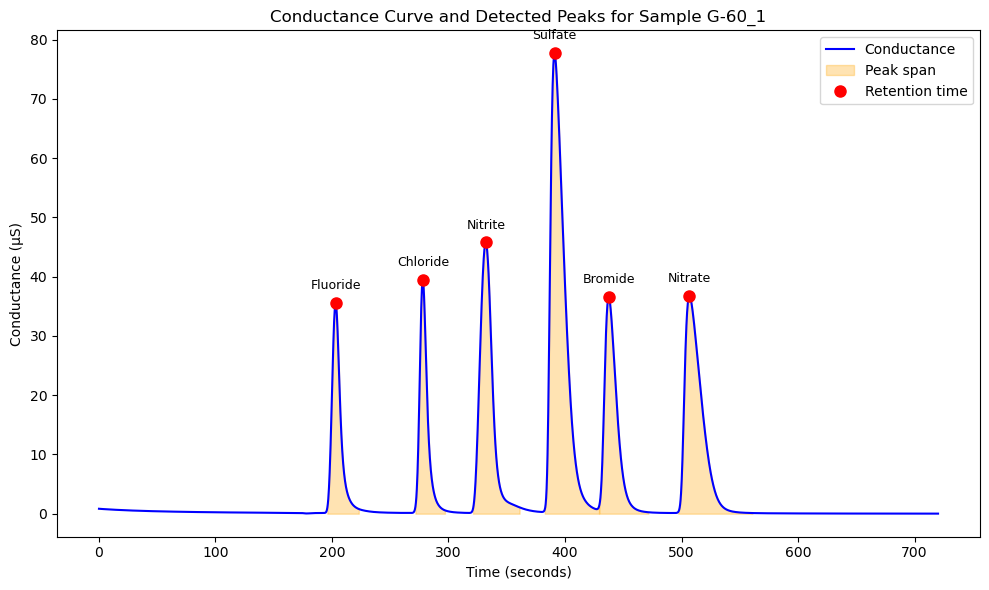

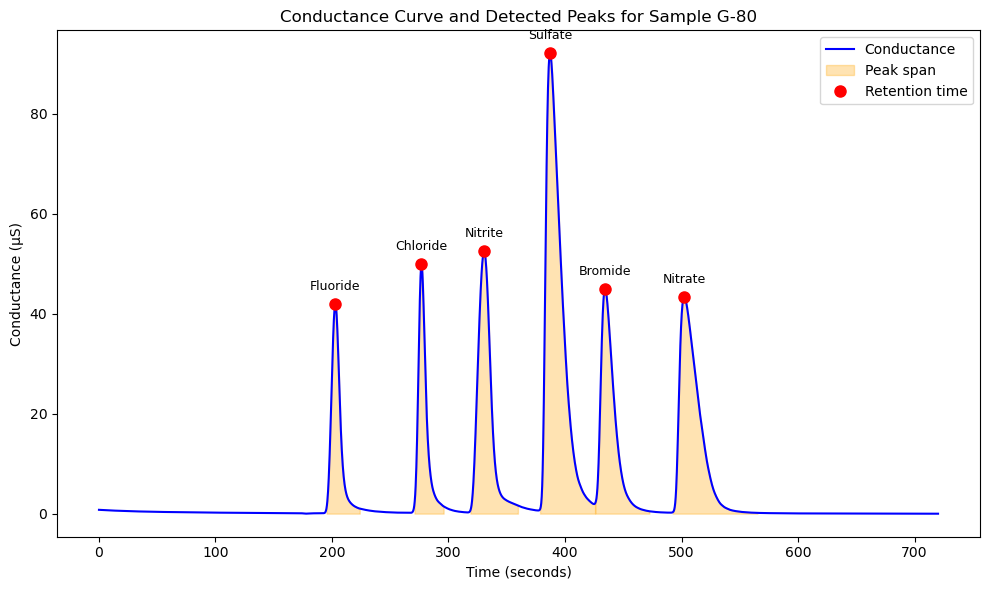

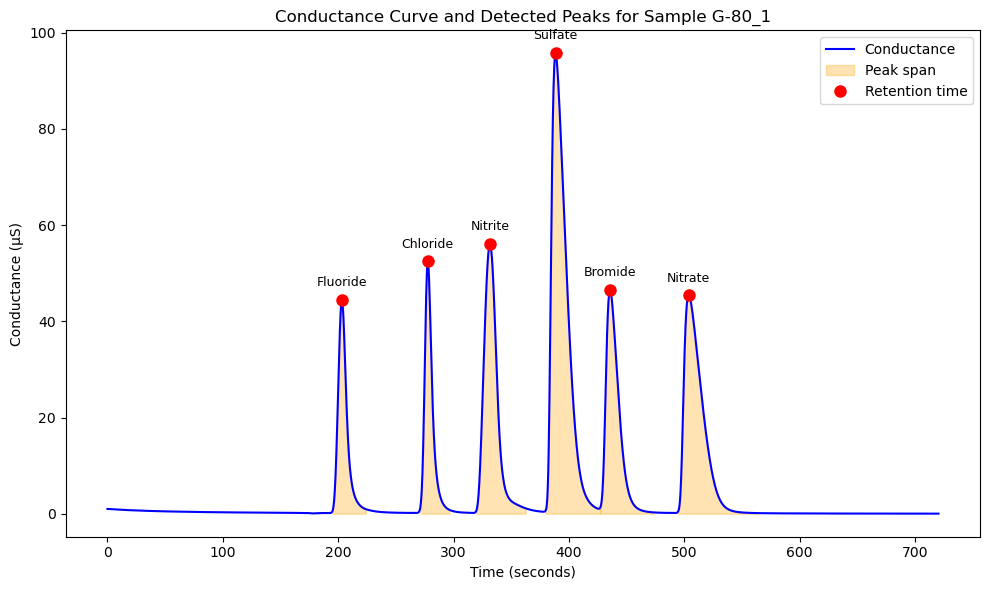

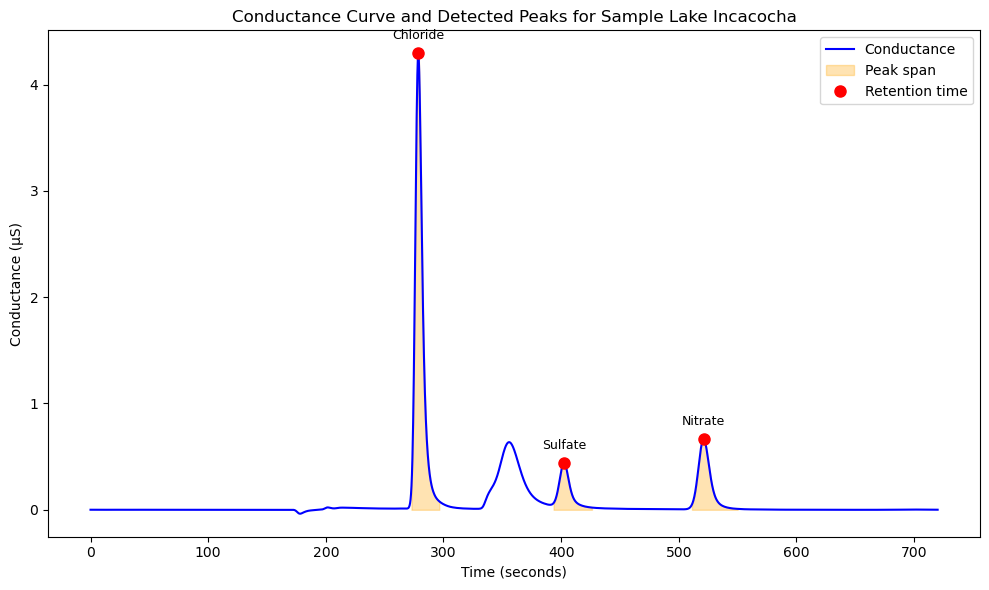

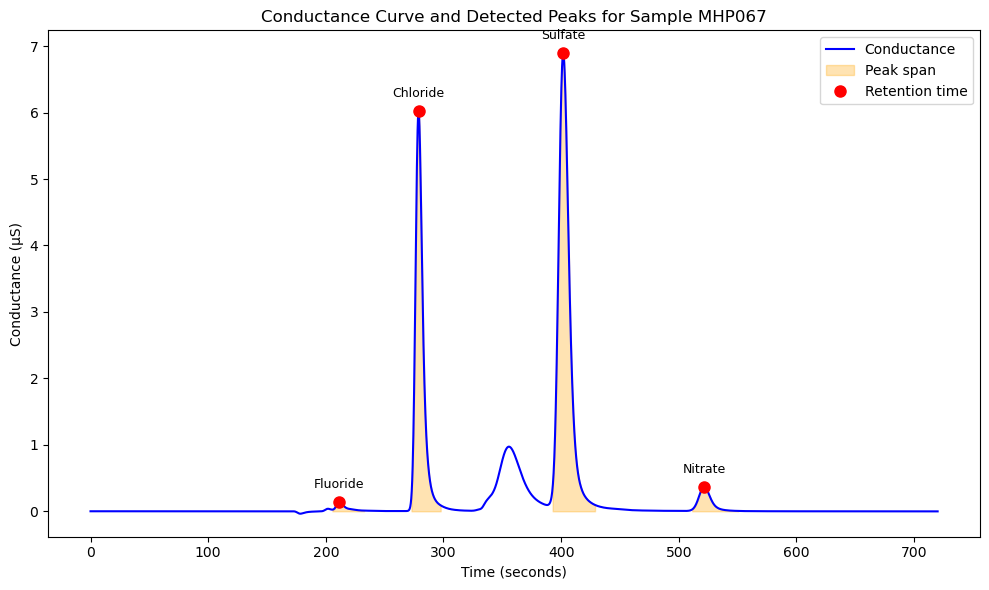

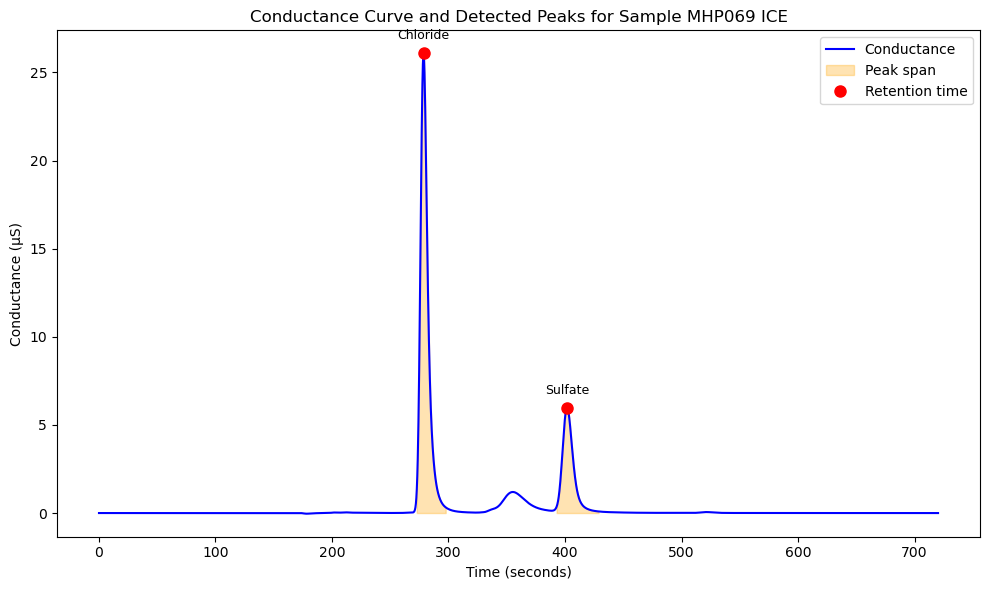

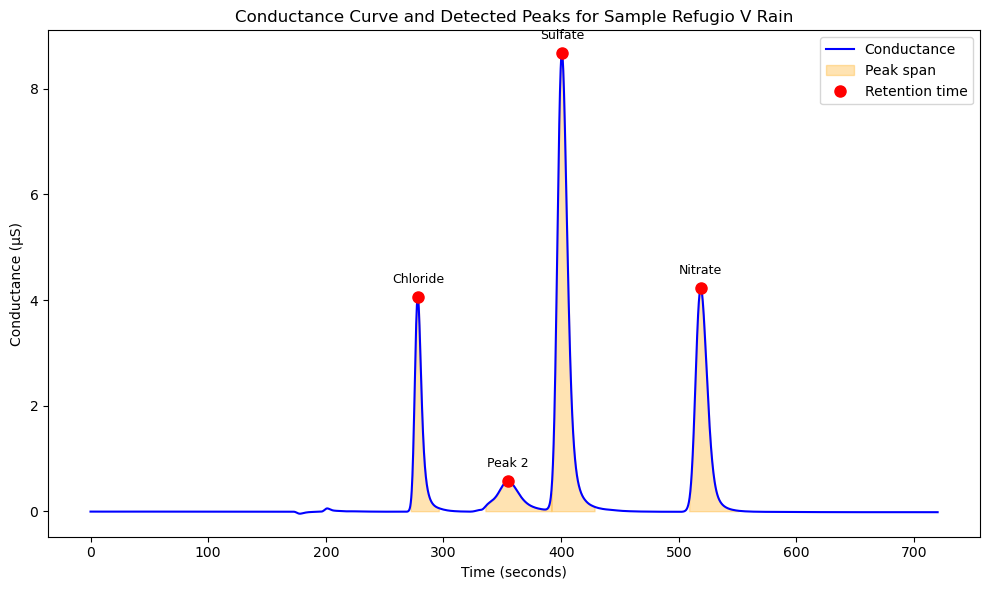

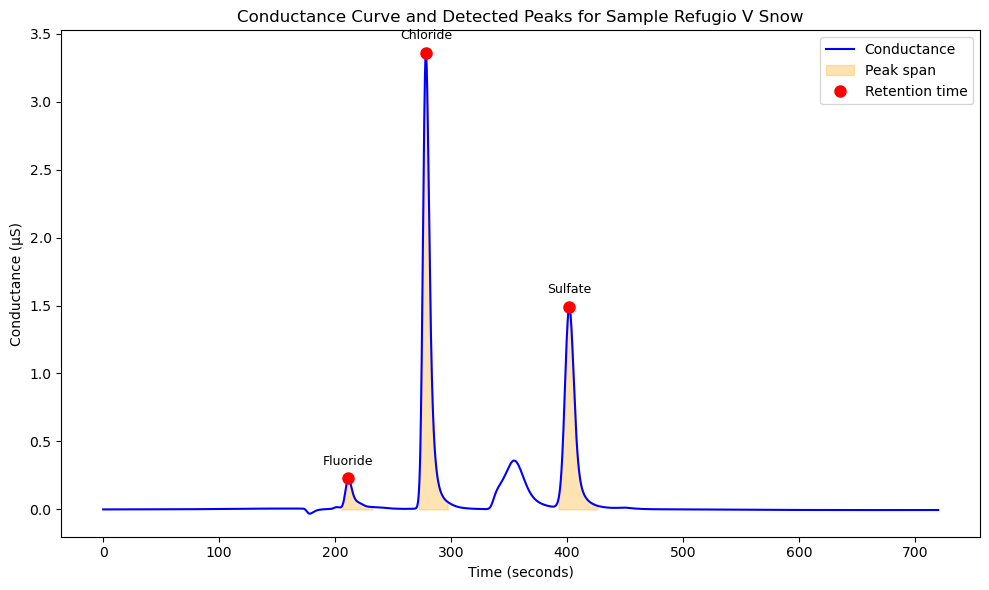

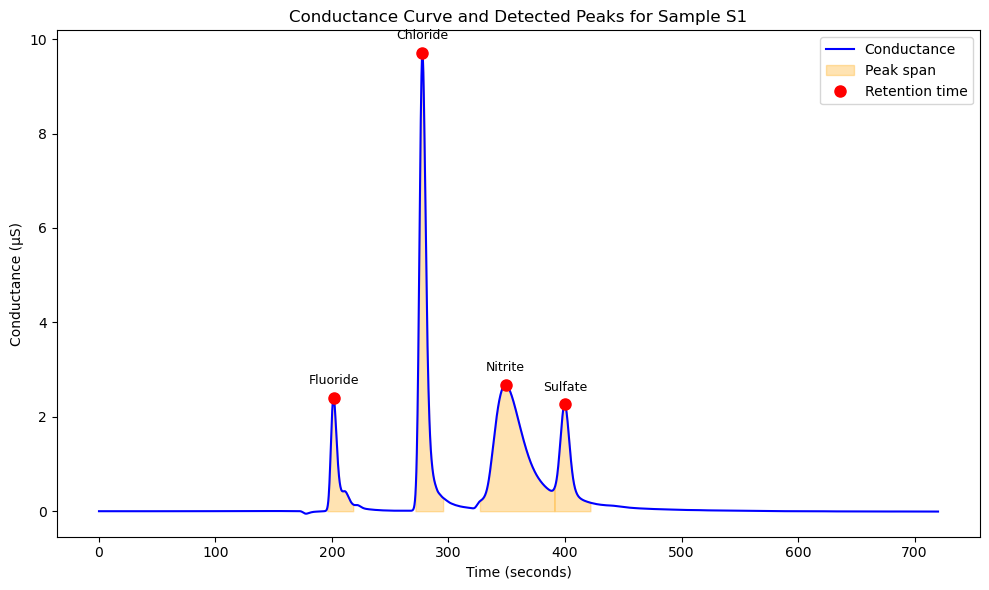

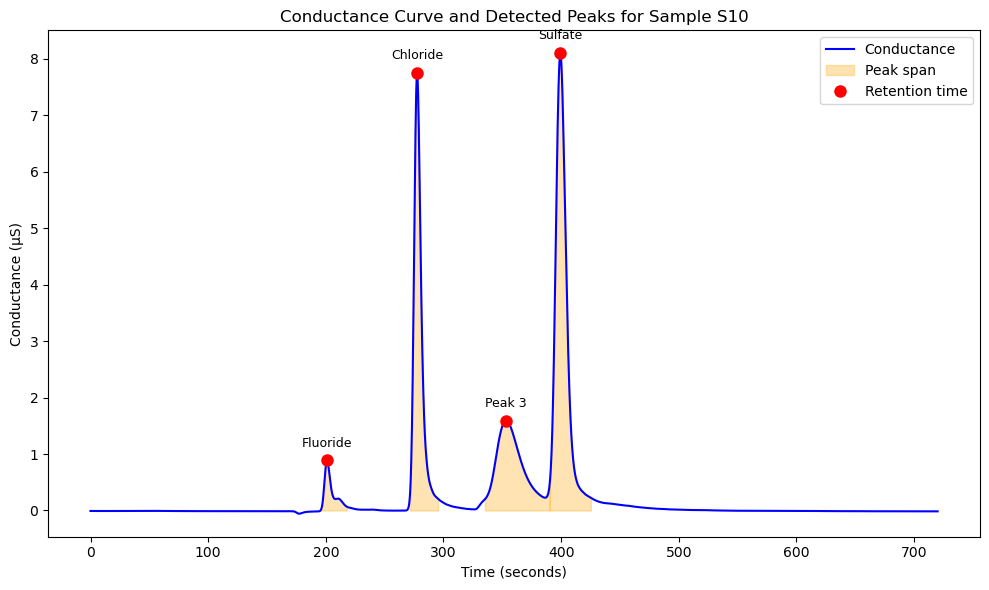

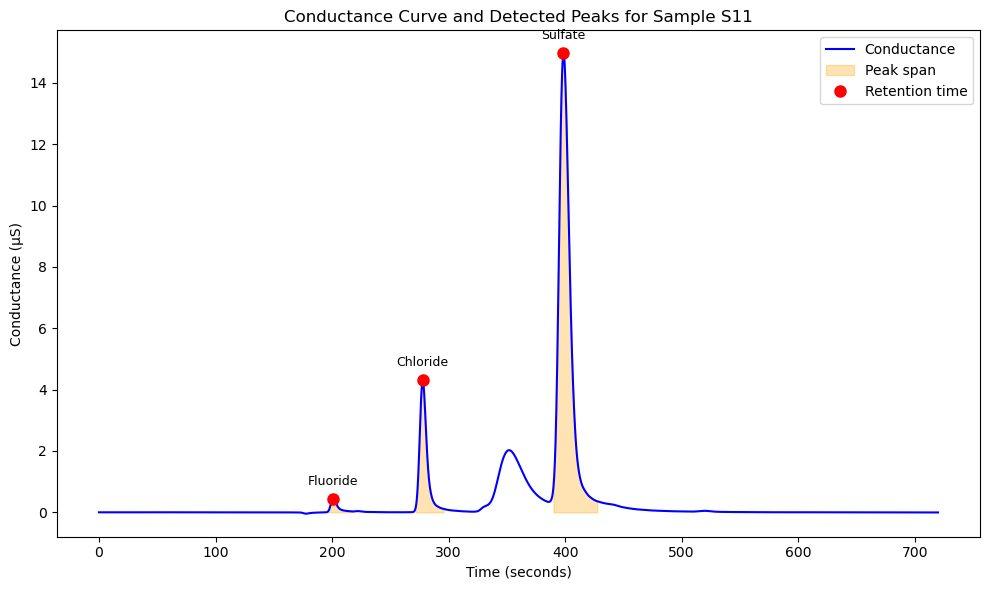

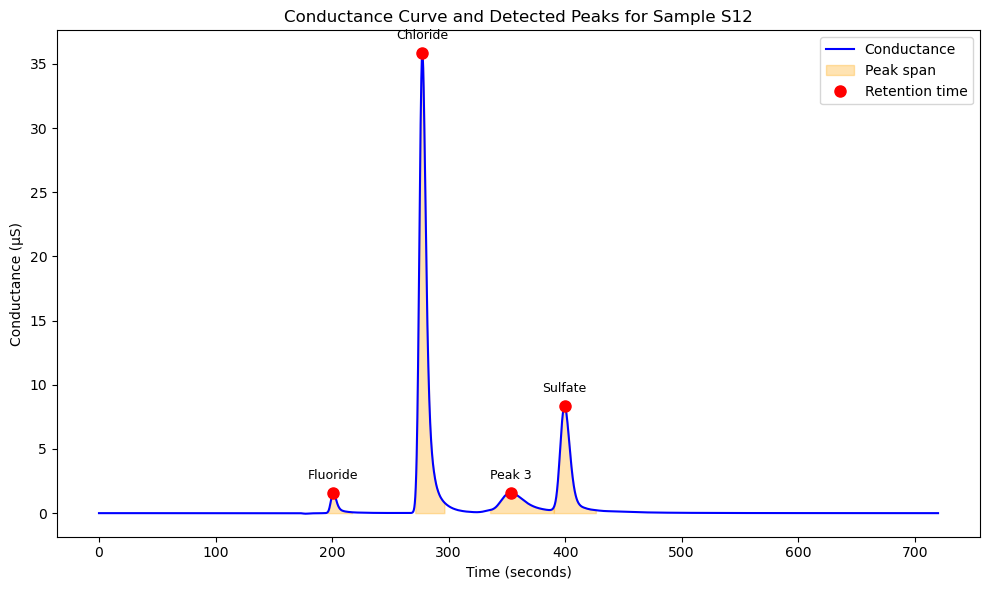

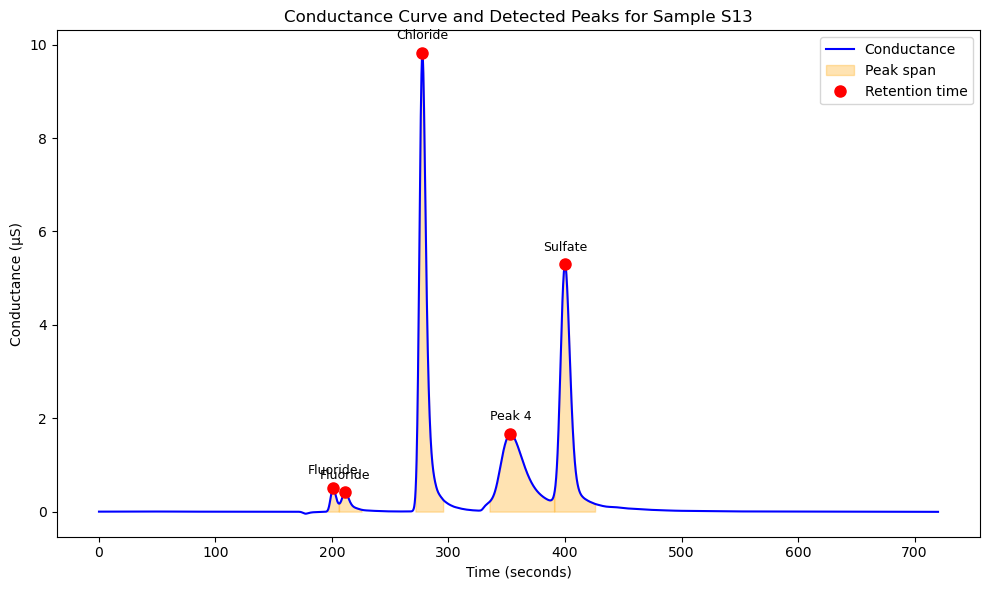

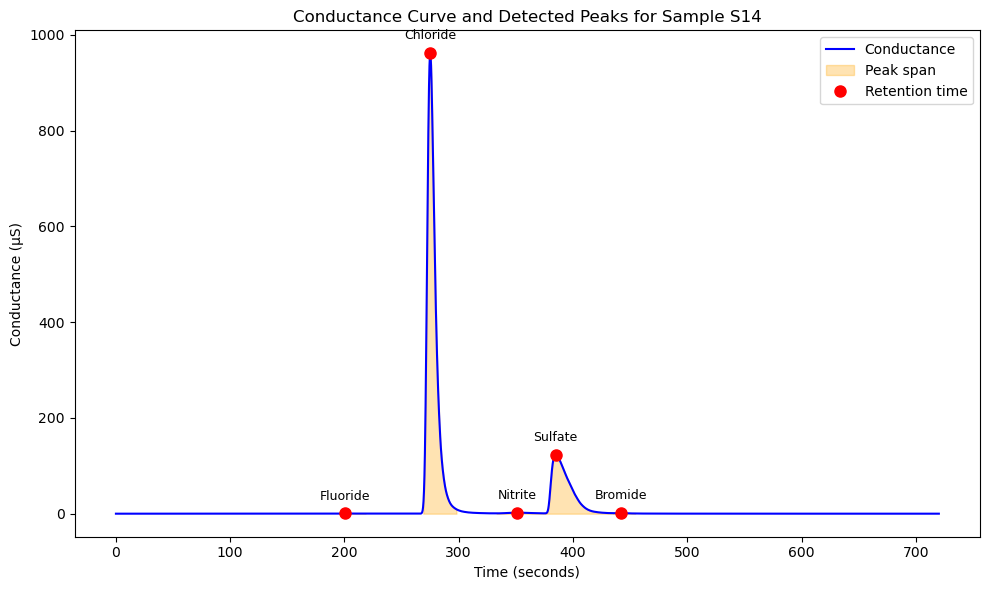

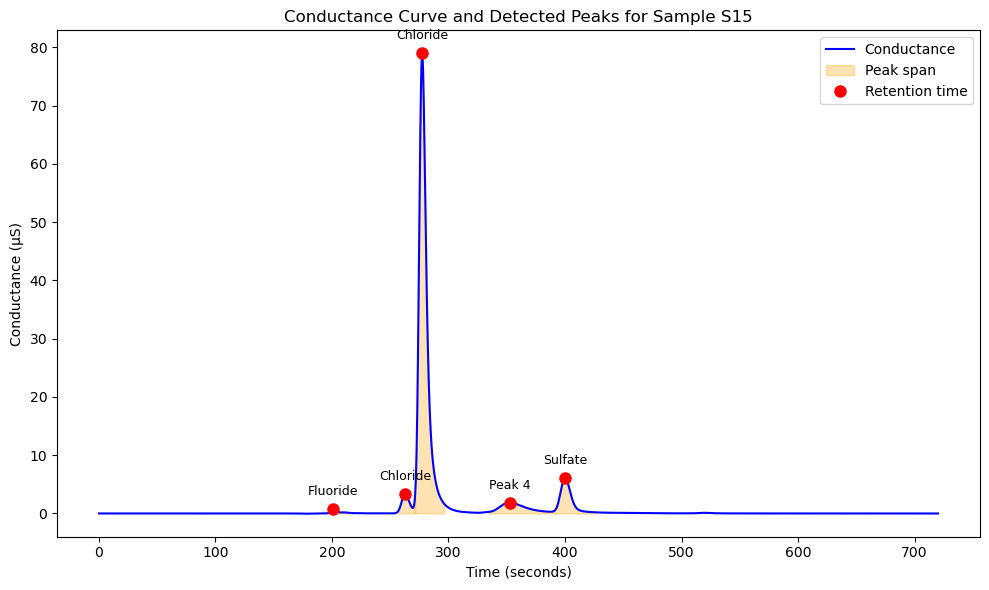

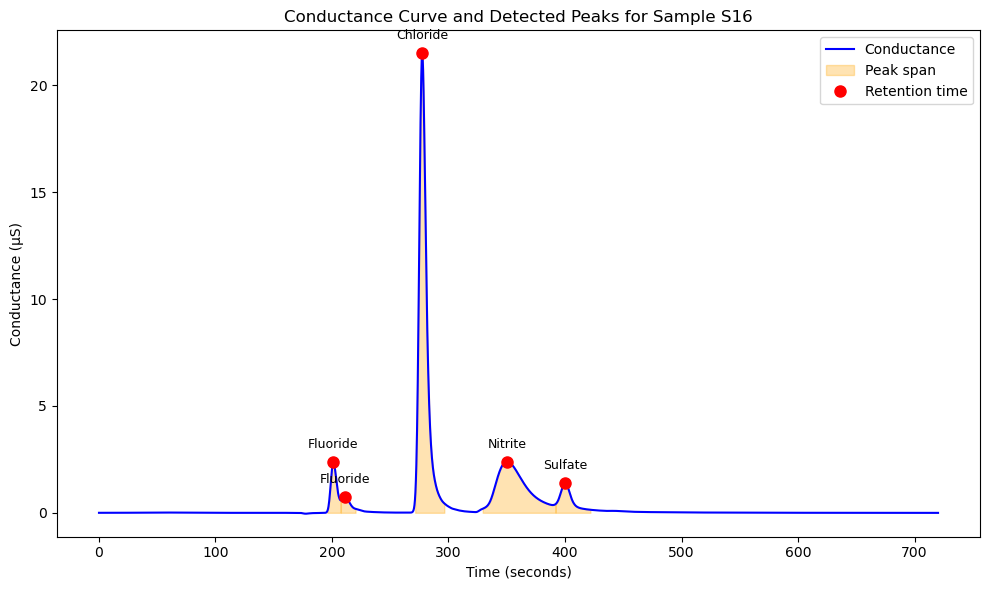

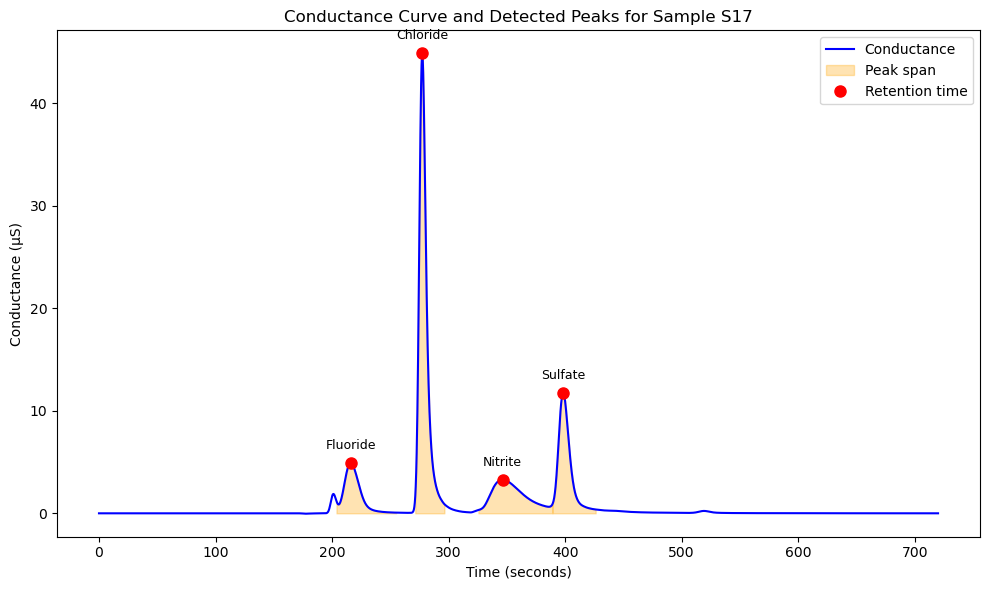

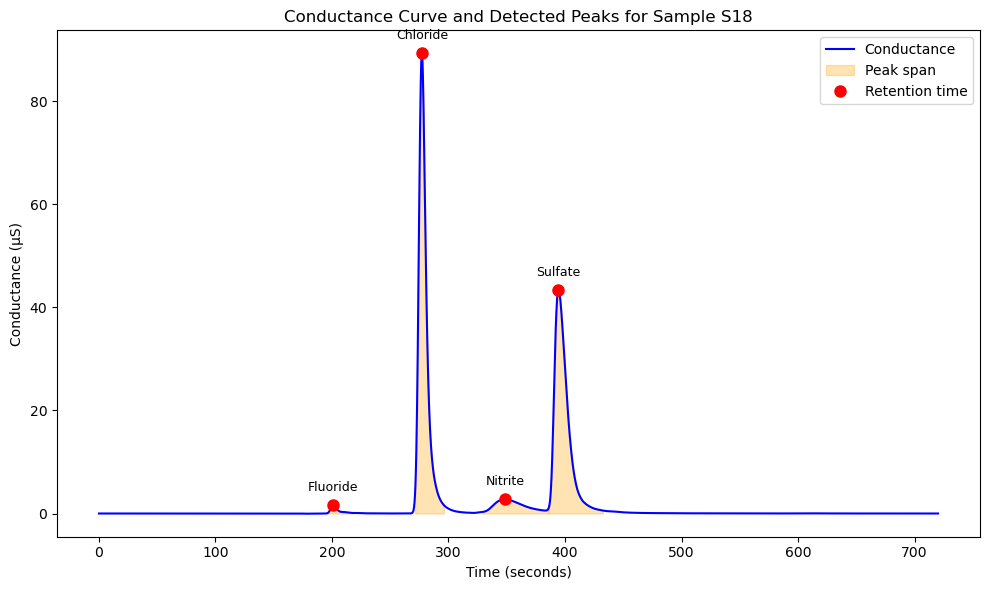

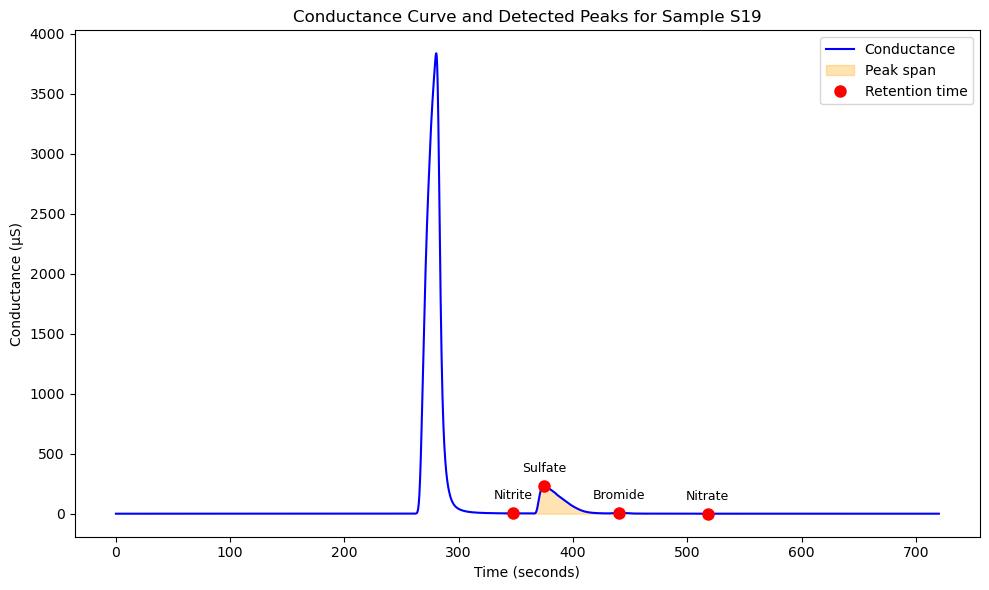

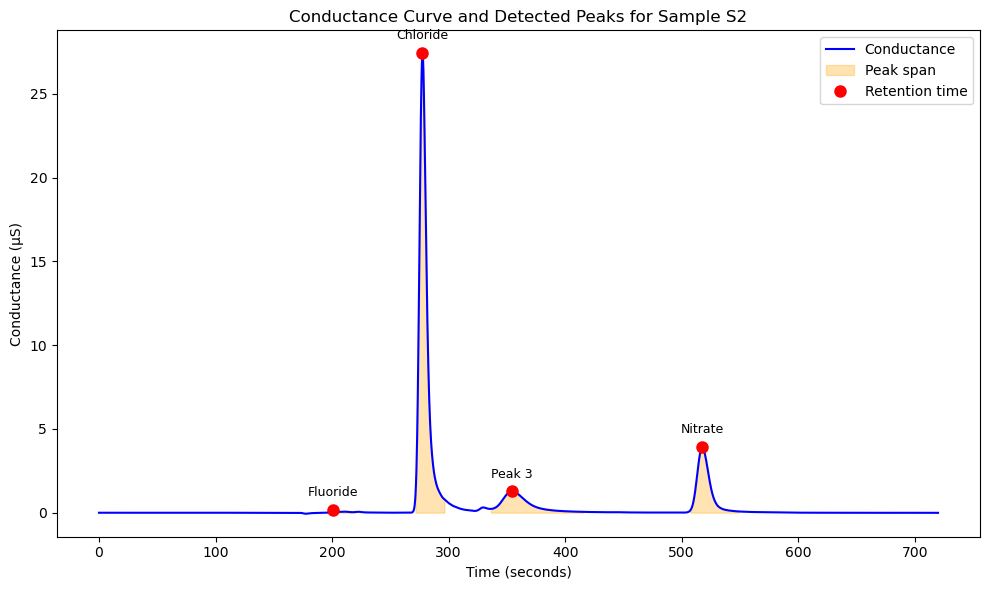

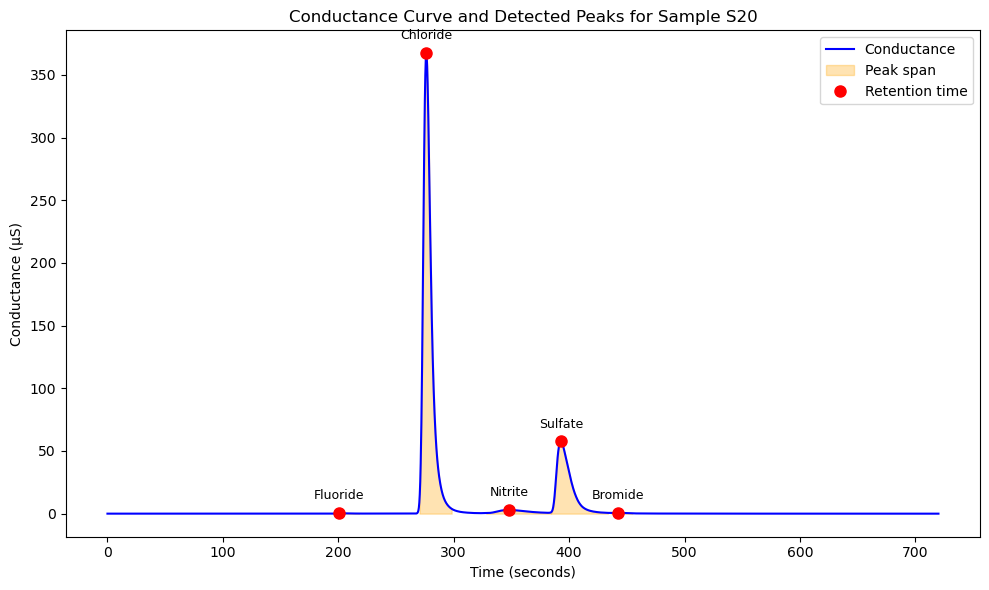

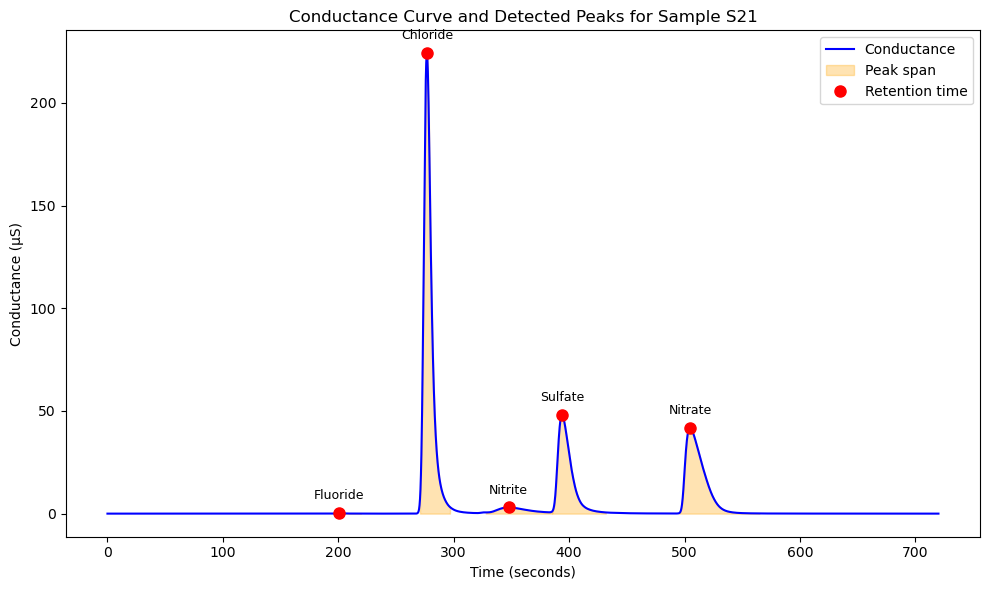

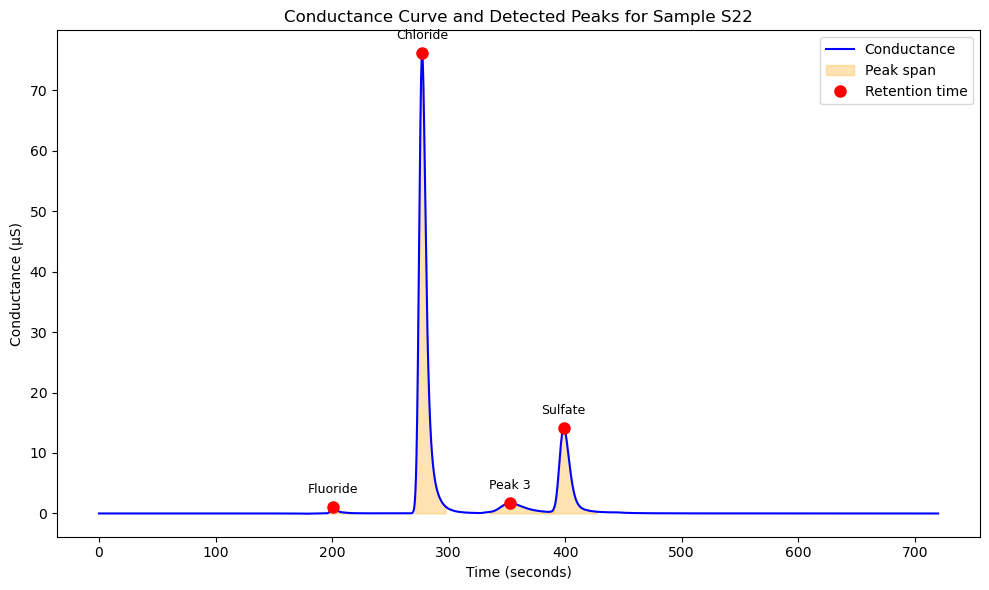

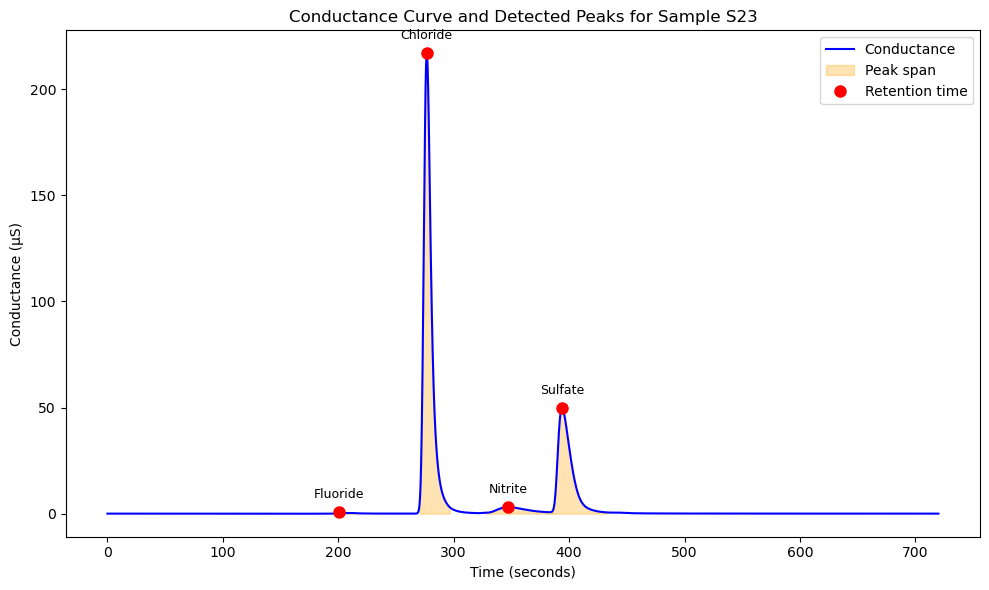

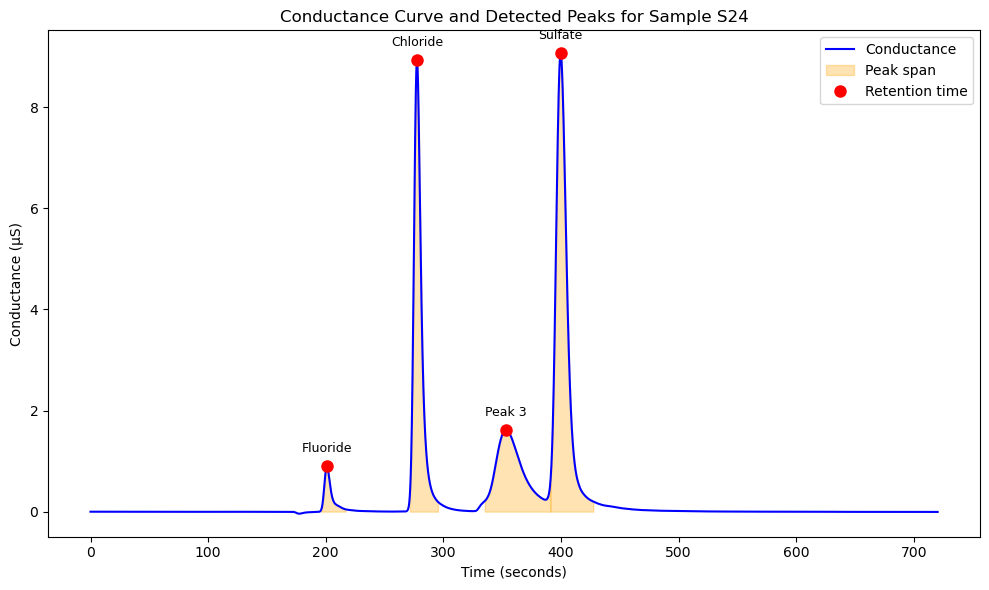

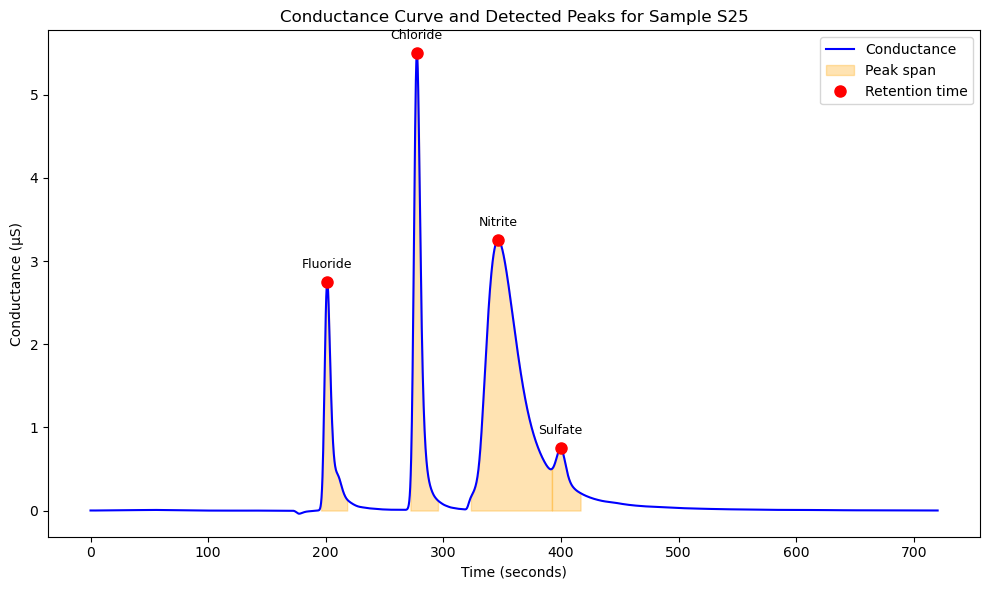

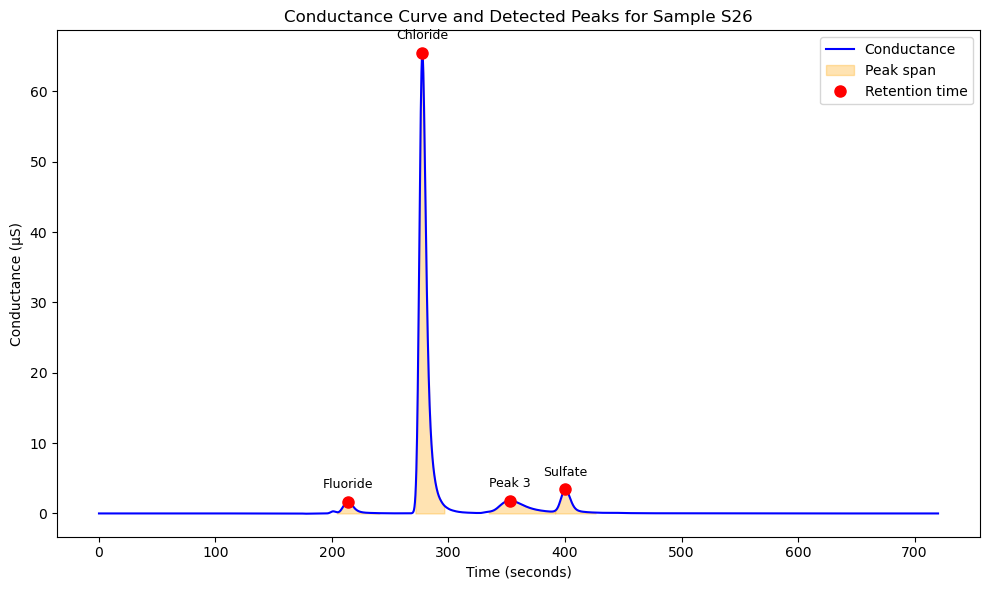

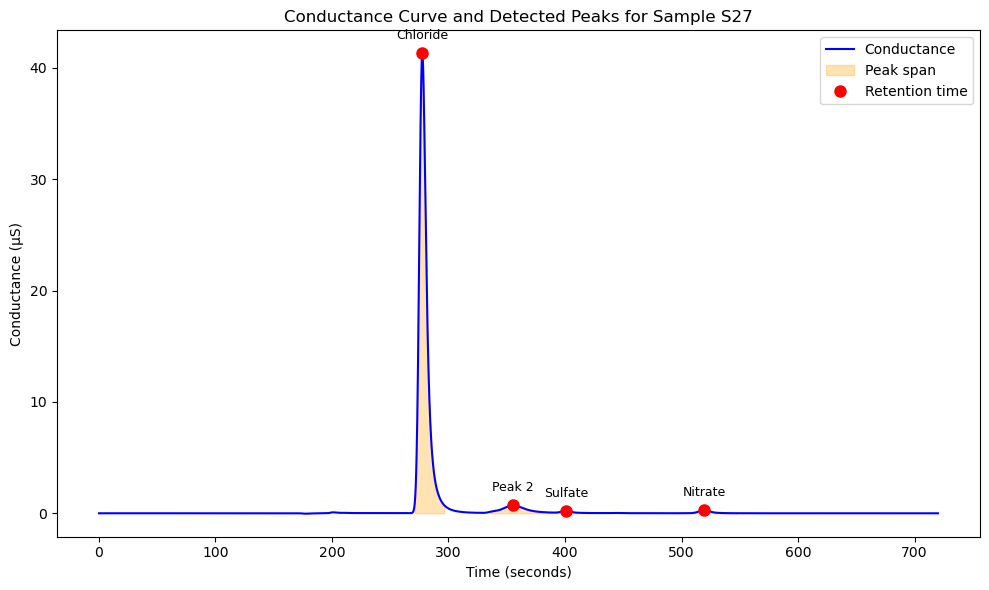

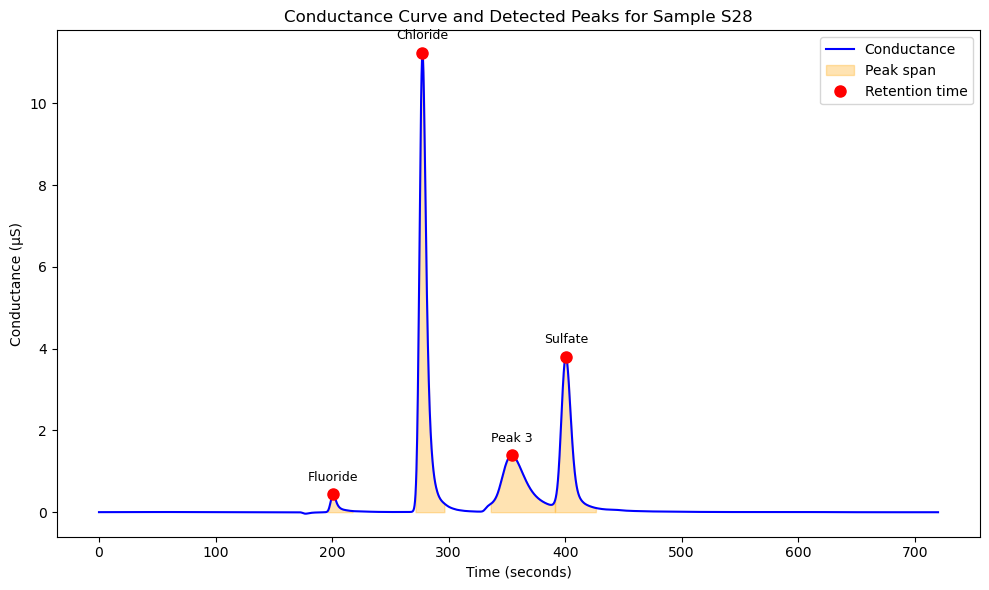

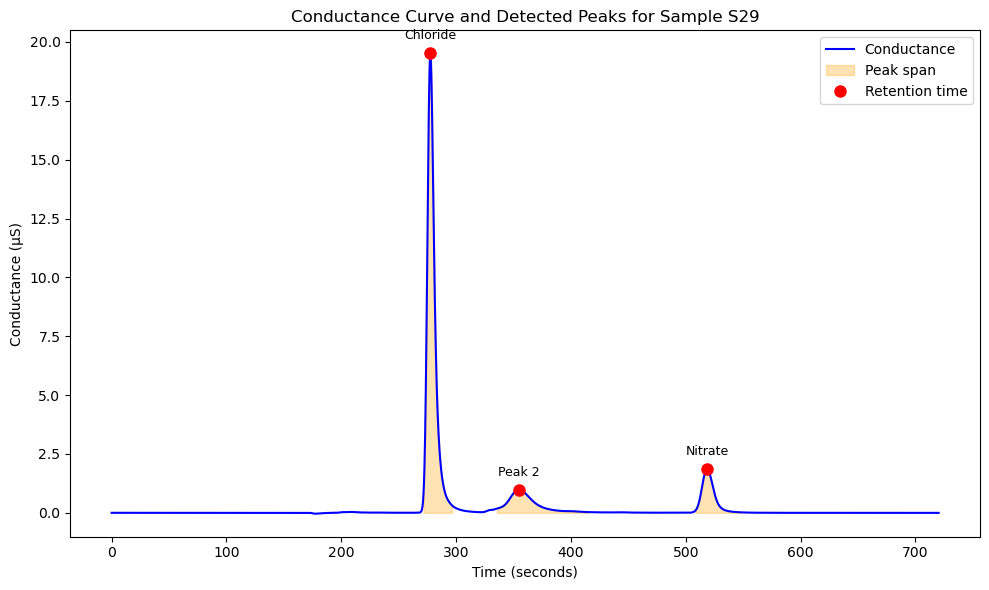

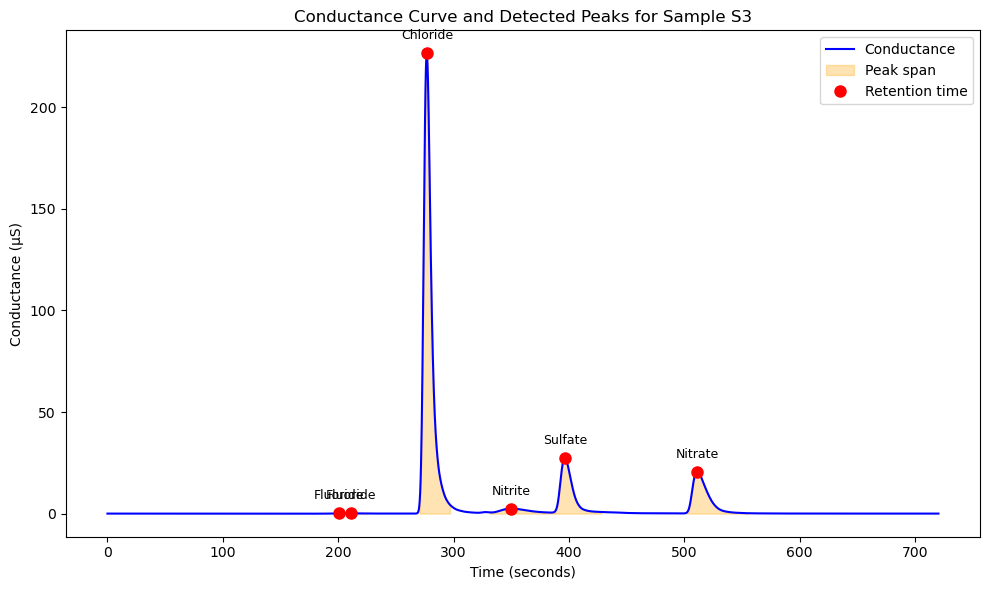

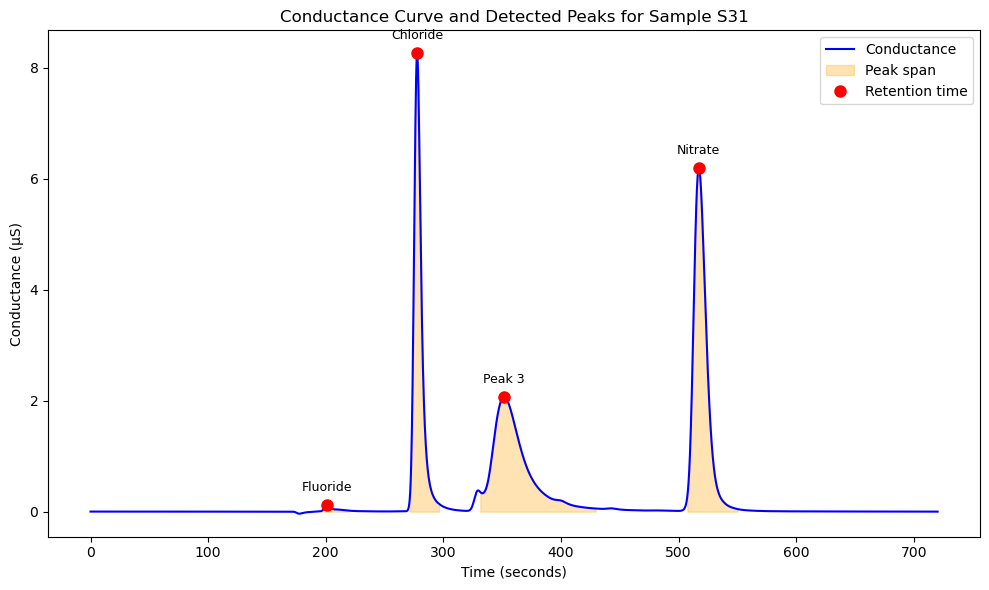

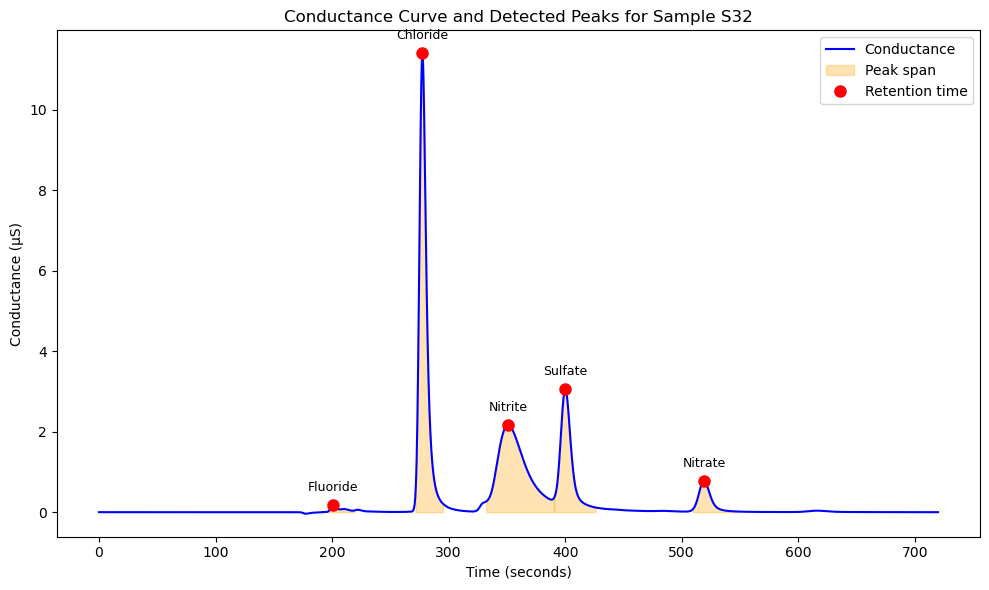

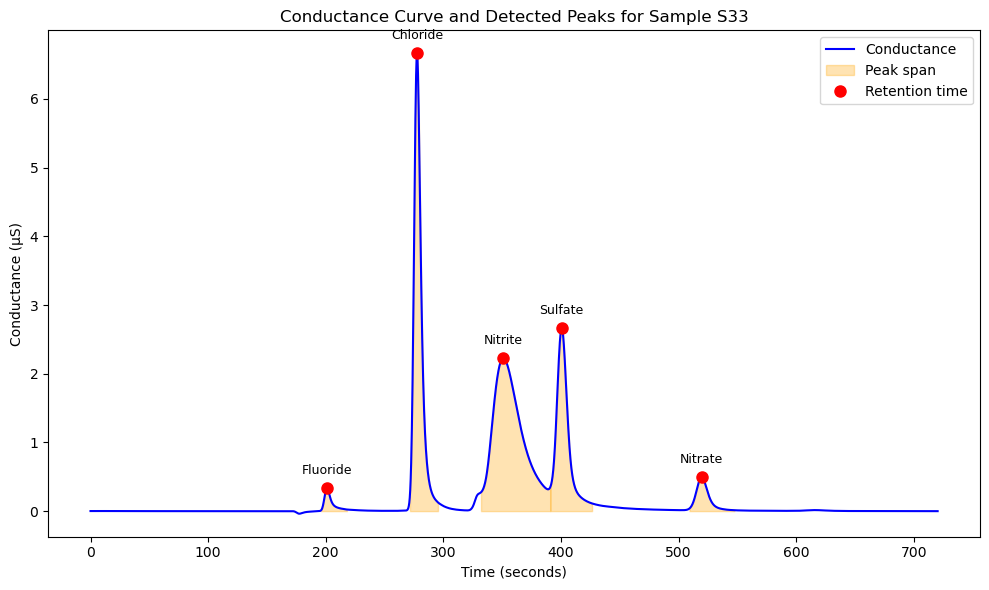

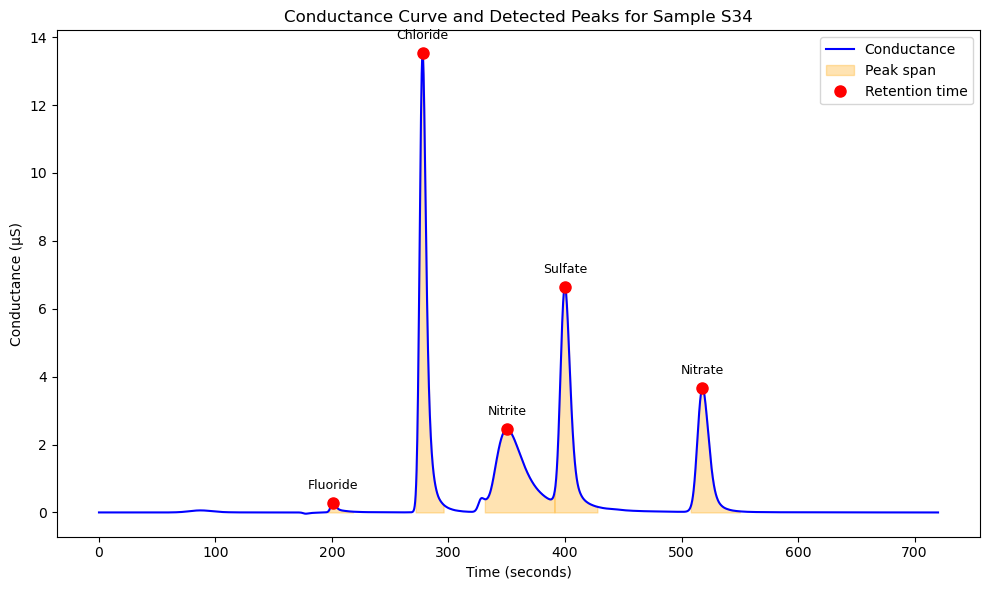

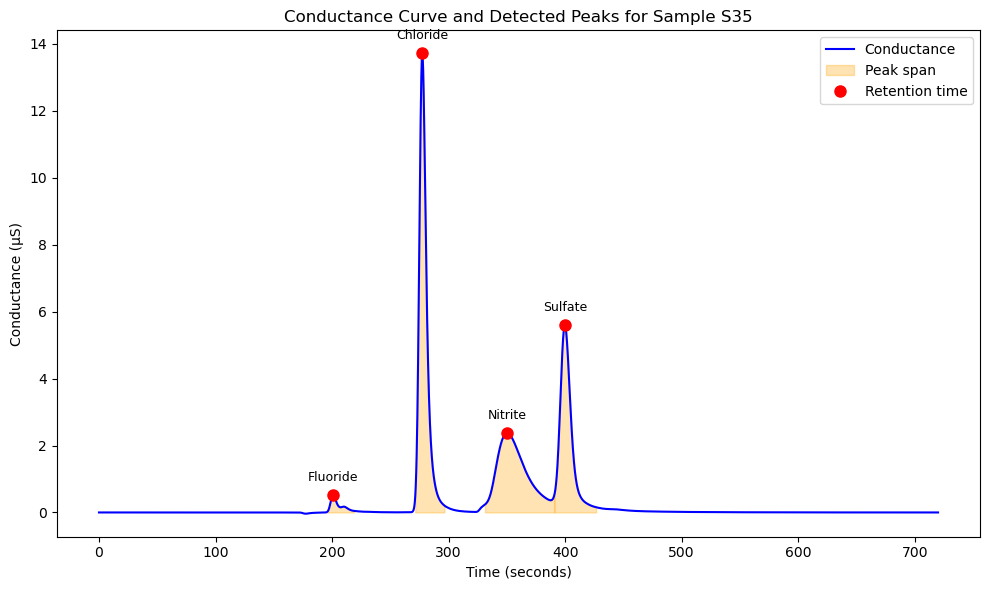

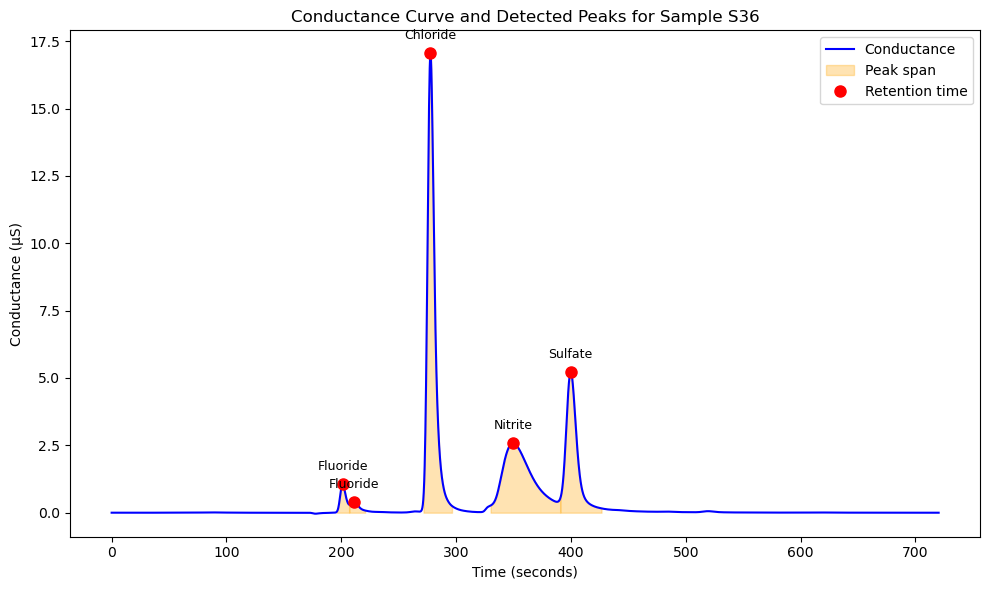

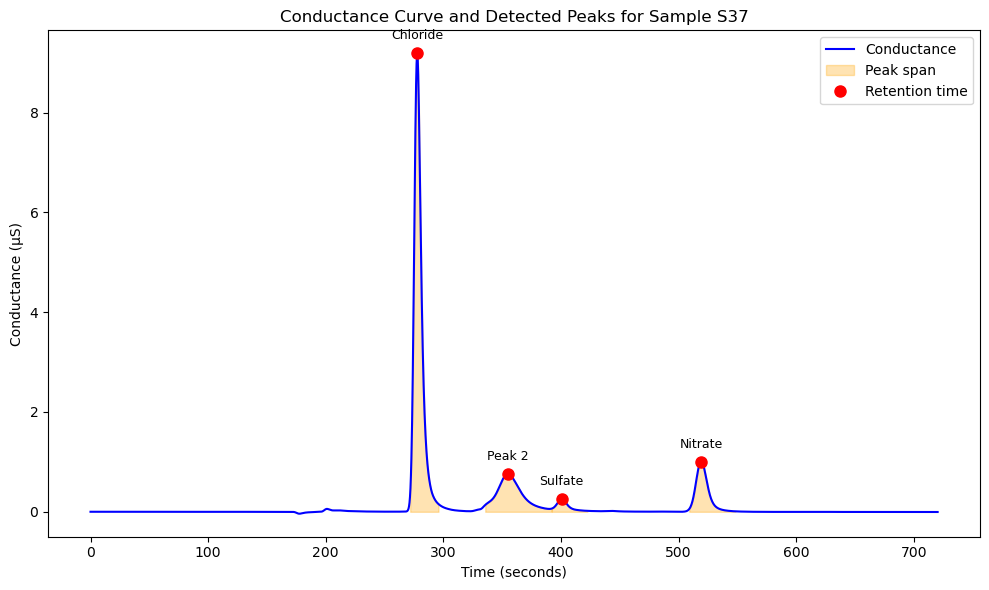

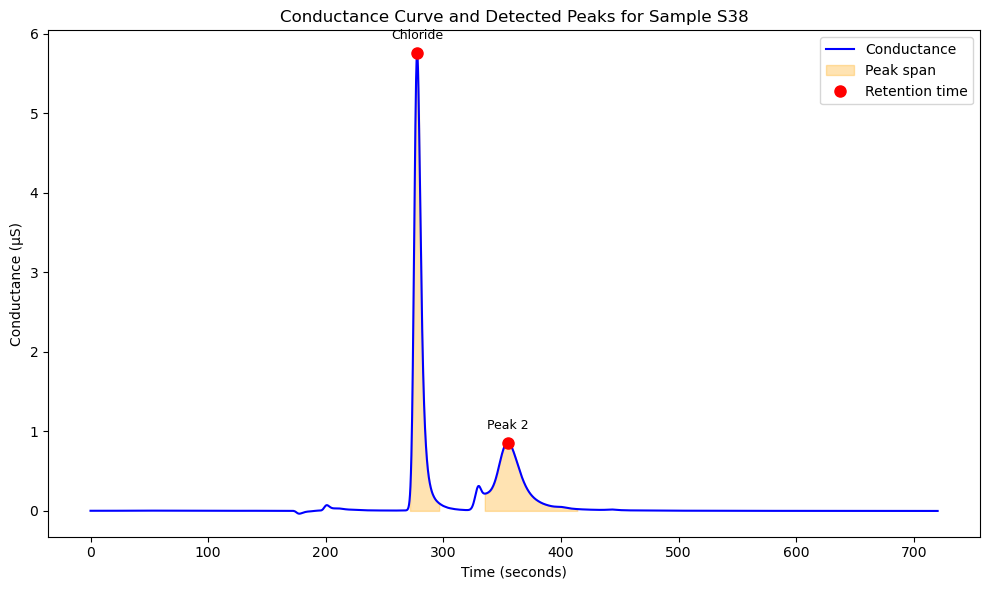

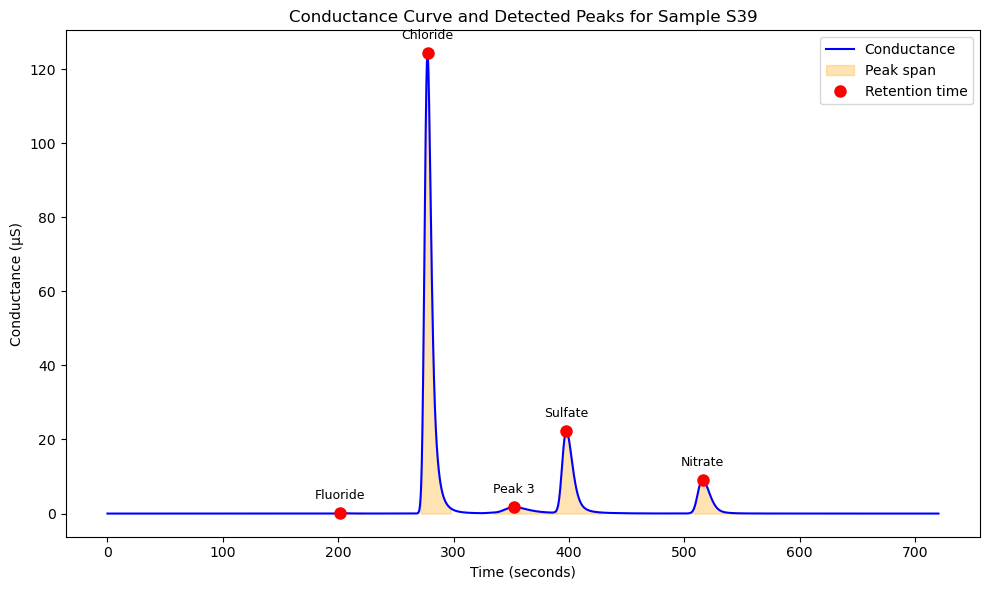

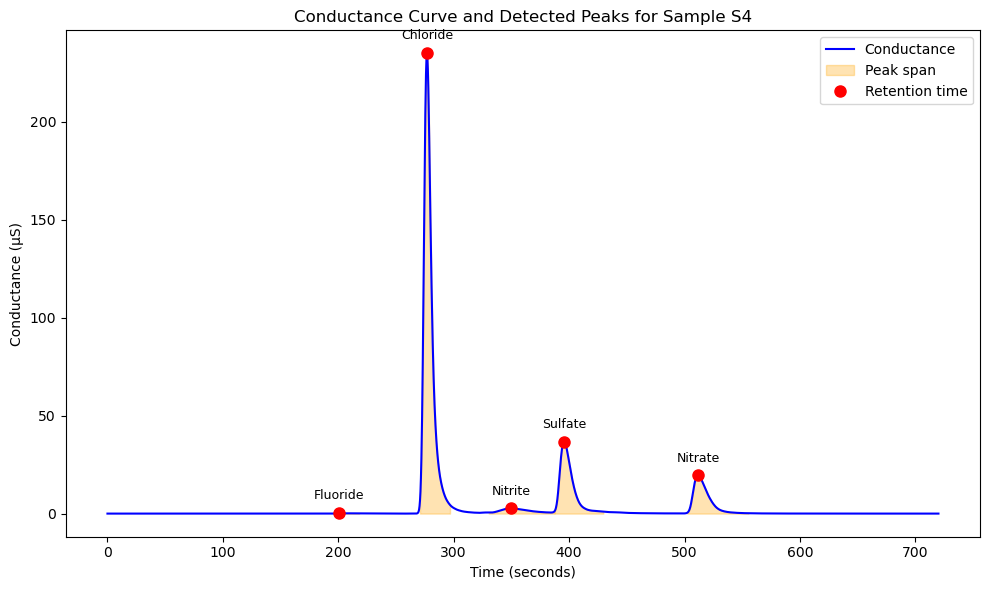

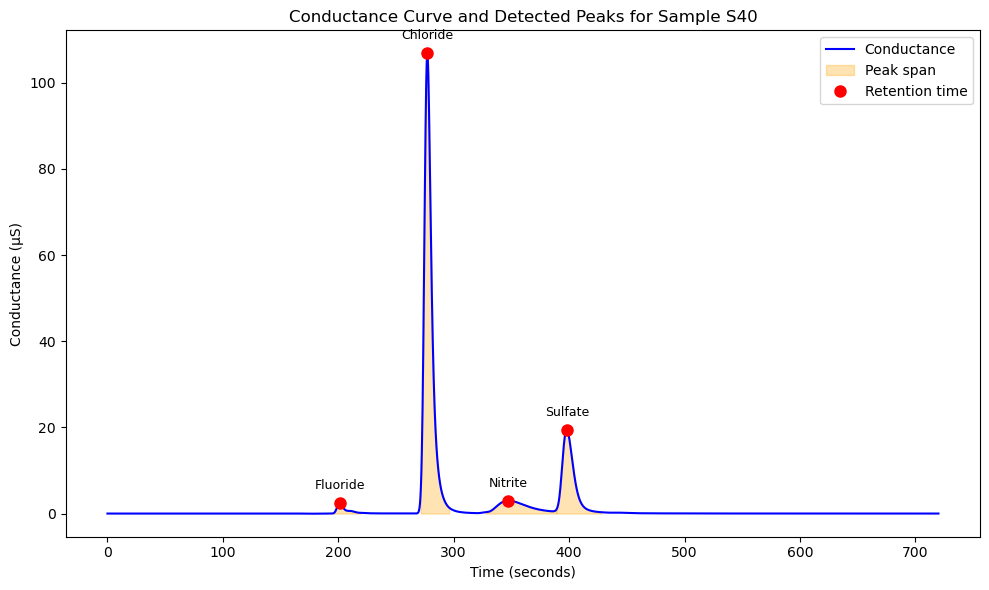

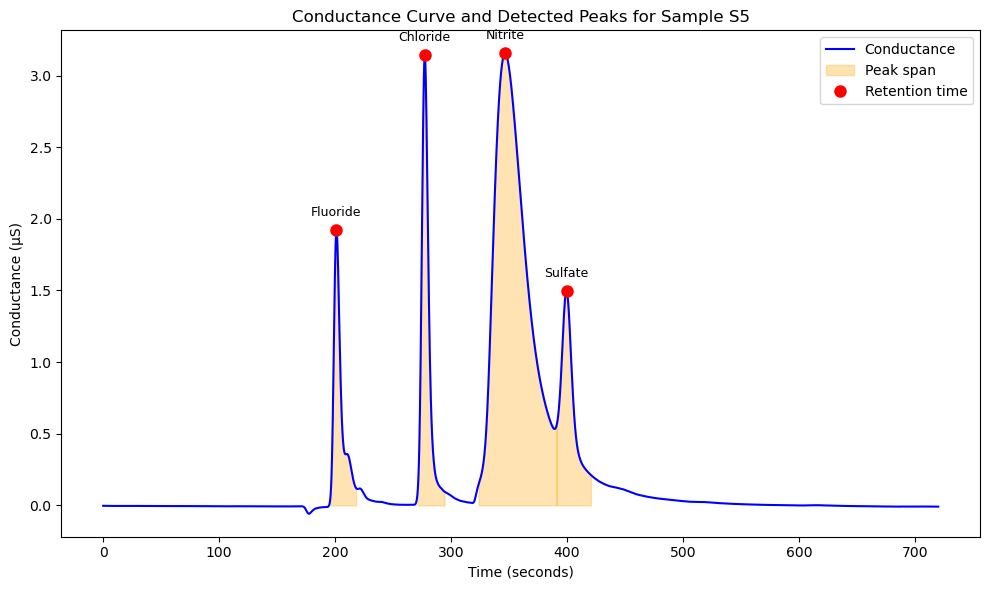

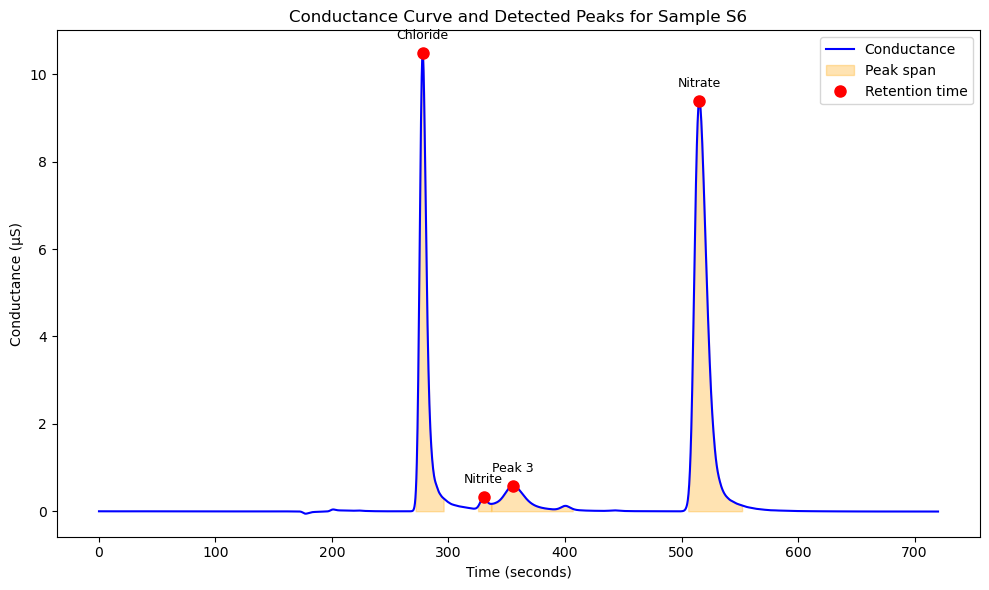

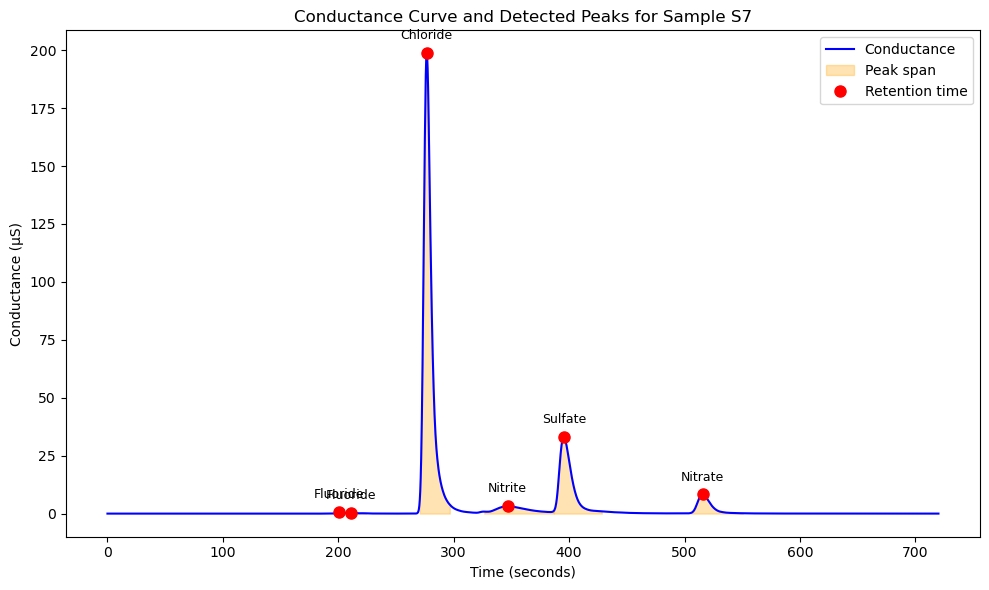

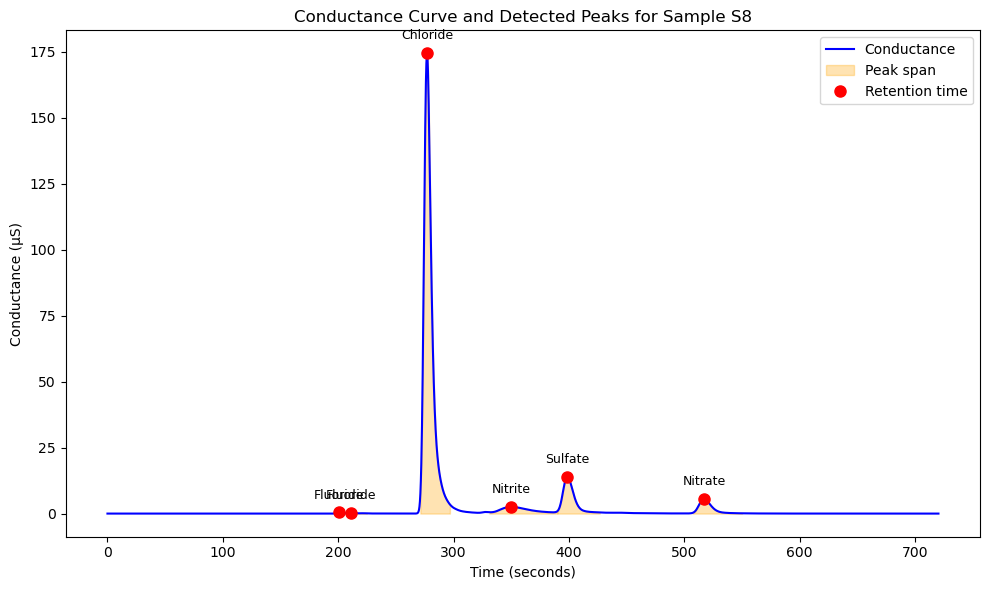

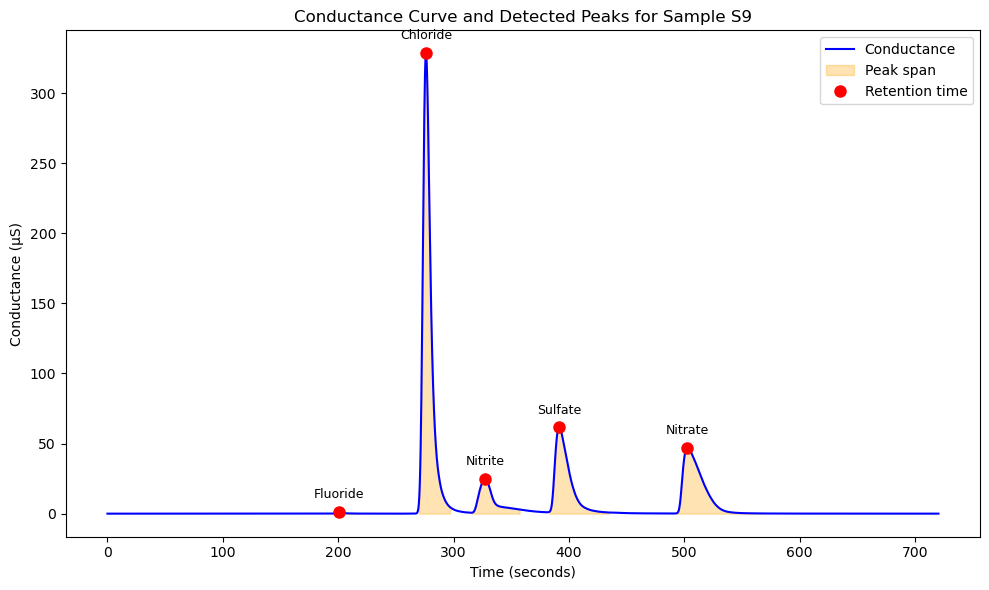

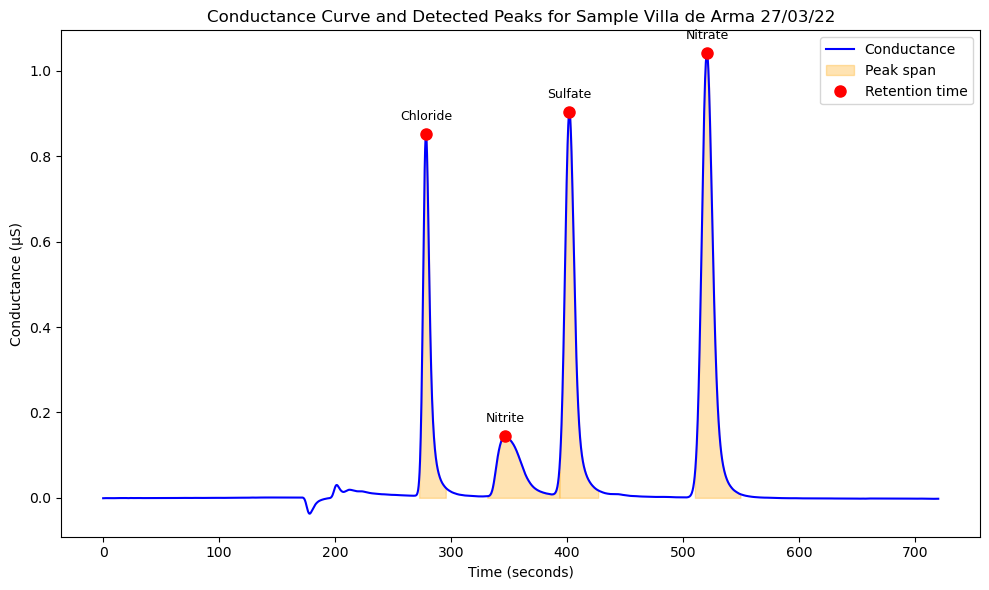

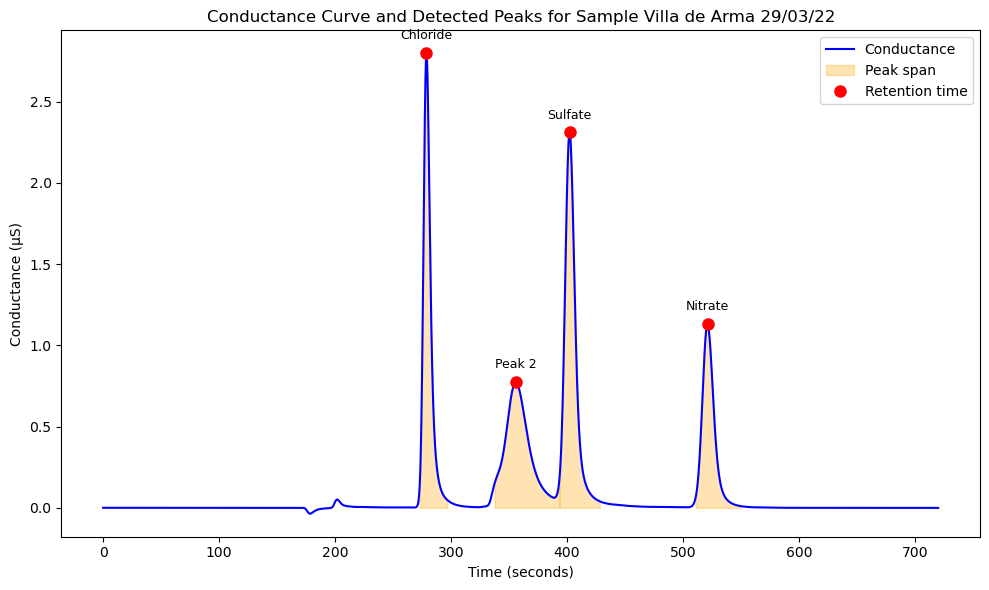

In [9]:
from dionexus.plotting import plot_sample_peaks

for sample in ds['sample'].values:
    plot_sample_peaks(ds, sample)